
🔍 Feature: loan_amnt


✅ Total IV for loan_amnt: 0.0277
╒══════════════════════╤═════════╤════════════════════╤══════════════════════╤═════════════╕
│ Bin                  │   Count │   Default Rate (%) │ WOE                  │          IV │
╞══════════════════════╪═════════╪════════════════════╪══════════════════════╪═════════════╡
│ (-inf, 4212.50)      │   17426 │             0.0799 │ 0.33301455593719353  │ 0.00777812  │
├──────────────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [4212.50, 5012.50)   │   11182 │             0.0885 │ 0.2206980849119704   │ 0.00229102  │
├──────────────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [5012.50, 7037.50)   │   18143 │             0.0921 │ 0.17728437034089328  │ 0.00243991  │
├──────────────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [7037.50, 10012.50)  │   39753 │             0.0961 │ 0.13073996449566305  │ 0.00296112  │
├──────────────────────┼─────────┼───

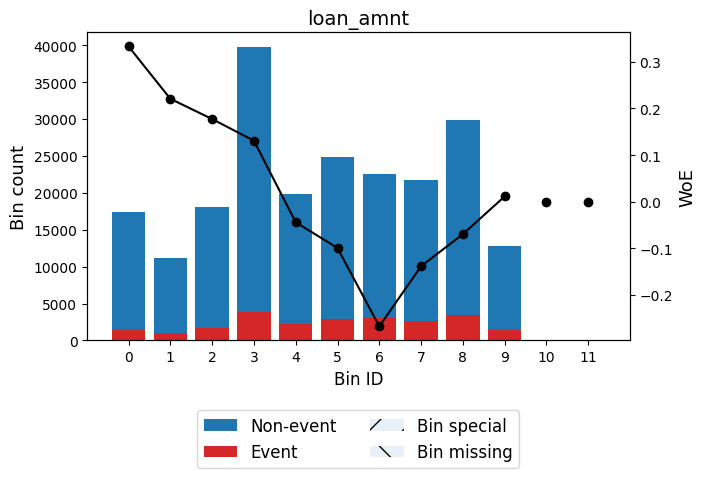


🔍 Feature: term
✅ Total IV for term: 0.0731
╒═══════════════╤═════════╤════════════════════╤═════════════════════╤═══════════╕
│ Bin           │   Count │   Default Rate (%) │ WOE                 │        IV │
╞═══════════════╪═════════╪════════════════════╪═════════════════════╪═══════════╡
│ (-inf, 48.00) │  155444 │             0.0908 │ 0.19235175980382557 │ 0.0244634 │
├───────────────┼─────────┼────────────────────┼─────────────────────┼───────────┤
│ [48.00, inf)  │   62547 │             0.1508 │ -0.3822295423979114 │ 0.0486122 │
├───────────────┼─────────┼────────────────────┼─────────────────────┼───────────┤
│ Special       │       0 │             0      │ 0.0                 │ 0         │
├───────────────┼─────────┼────────────────────┼─────────────────────┼───────────┤
│ Missing       │       0 │             0      │ 0.0                 │ 0         │
├───────────────┼─────────┼────────────────────┼─────────────────────┼───────────┤
│               │  217991 │             0.

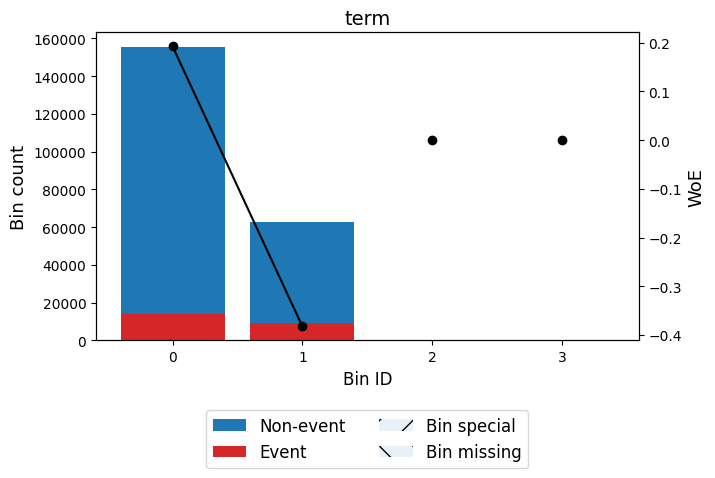


🔍 Feature: annual_inc
✅ Total IV for annual_inc: 0.0286
╒════════════════════════╤═════════╤════════════════════╤═══════════════════════╤═════════════╕
│ Bin                    │   Count │   Default Rate (%) │ WOE                   │          IV │
╞════════════════════════╪═════════╪════════════════════╪═══════════════════════╪═════════════╡
│ (-inf, 44236.50)       │   46760 │             0.1261 │ -0.17536812434680238  │ 0.00706435  │
├────────────────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ [44236.50, 54984.50)   │   30244 │             0.1215 │ -0.13276335980475062  │ 0.00257569  │
├────────────────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ [54984.50, 64967.00)   │   27082 │             0.1145 │ -0.06505391230519741  │ 0.000539324 │
├────────────────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ [64967.00, 74402.00)   │   24050 │             0.1078 │ 0.0022800761350785237

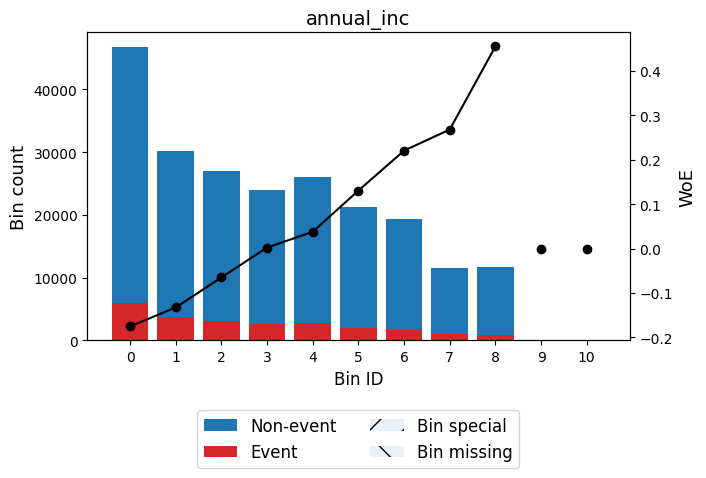


🔍 Feature: dti
✅ Total IV for dti: 0.0540
╒════════════════╤═════════╤════════════════════╤═══════════════════════╤═════════════╕
│ Bin            │   Count │   Default Rate (%) │ WOE                   │          IV │
╞════════════════╪═════════╪════════════════════╪═══════════════════════╪═════════════╡
│ (-inf, 5.12)   │   11322 │             0.0682 │ 0.503941239108098     │ 0.0108239   │
├────────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ [5.12, 7.42)   │   10940 │             0.0763 │ 0.38239855521552757   │ 0.00631523  │
├────────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ [7.42, 10.48)  │   20410 │             0.0827 │ 0.29519955700444944   │ 0.00726561  │
├────────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ [10.48, 12.99) │   21067 │             0.0894 │ 0.2102549988388045    │ 0.00393359  │
├────────────────┼─────────┼────────────────────┼───────────────────────┼────

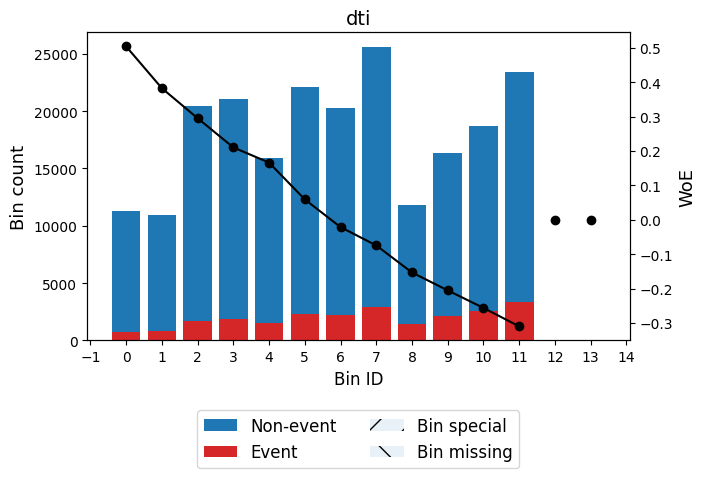


🔍 Feature: delinq_2yrs
✅ Total IV for delinq_2yrs: 0.0068
╒══════════════╤═════════╤════════════════════╤══════════════════════╤═════════════╕
│ Bin          │   Count │   Default Rate (%) │ WOE                  │          IV │
╞══════════════╪═════════╪════════════════════╪══════════════════════╪═════════════╡
│ (-inf, 0.50) │  177492 │             0.1046 │ 0.03639202376418904  │ 0.00106305  │
├──────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [0.50, 1.50) │   27136 │             0.1168 │ -0.08805077840020248 │ 0.000998934 │
├──────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [1.50, inf)  │   13363 │             0.1361 │ -0.2630764278357536  │ 0.00470016  │
├──────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ Special      │       0 │             0      │ 0.0                  │ 0           │
├──────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ Miss

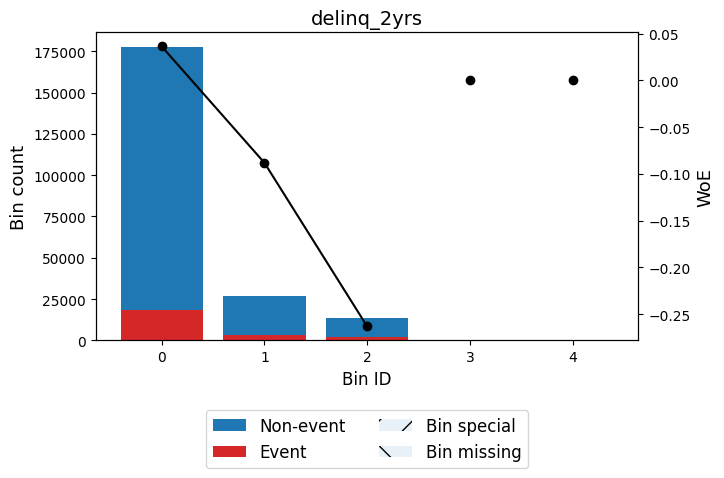


🔍 Feature: inq_last_6mths
✅ Total IV for inq_last_6mths: 0.0628
╒══════════════╤═════════╤════════════════════╤══════════════════════╤════════════╕
│ Bin          │   Count │   Default Rate (%) │ WOE                  │         IV │
╞══════════════╪═════════╪════════════════════╪══════════════════════╪════════════╡
│ (-inf, 0.50) │  133759 │             0.0905 │ 0.19642536220574724  │ 0.0219166  │
├──────────────┼─────────┼────────────────────┼──────────────────────┼────────────┤
│ [0.50, 1.50) │   56077 │             0.1219 │ -0.13626490207162156 │ 0.00503783 │
├──────────────┼─────────┼────────────────────┼──────────────────────┼────────────┤
│ [1.50, inf)  │   28155 │             0.1637 │ -0.48001030885370444 │ 0.0358119  │
├──────────────┼─────────┼────────────────────┼──────────────────────┼────────────┤
│ Special      │       0 │             0      │ 0.0                  │ 0          │
├──────────────┼─────────┼────────────────────┼──────────────────────┼────────────┤
│ Missing  

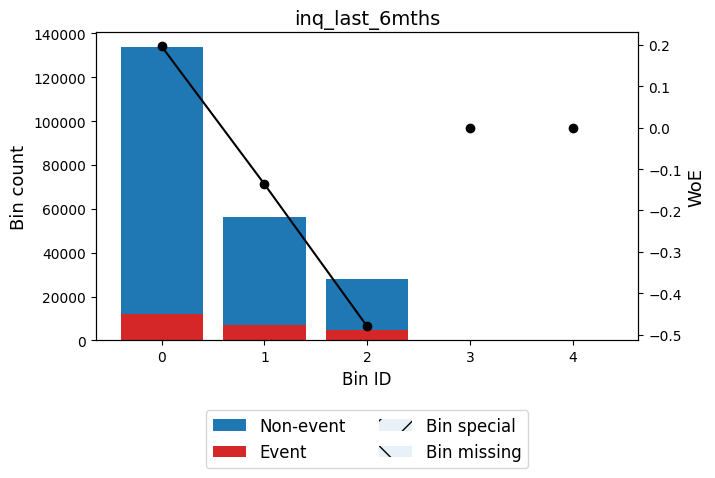


🔍 Feature: pub_rec
✅ Total IV for pub_rec: 0.0098
╒══════════════╤═════════╤════════════════════╤══════════════════════╤════════════╕
│ Bin          │   Count │   Default Rate (%) │ WOE                  │         IV │
╞══════════════╪═════════╪════════════════════╪══════════════════════╪════════════╡
│ (-inf, 0.50) │  183514 │             0.1038 │ 0.045137927316794446 │ 0.0016851  │
├──────────────┼─────────┼────────────────────┼──────────────────────┼────────────┤
│ [0.50, inf)  │   34477 │             0.1308 │ -0.21690060350855256 │ 0.00809737 │
├──────────────┼─────────┼────────────────────┼──────────────────────┼────────────┤
│ Special      │       0 │             0      │ 0.0                  │ 0          │
├──────────────┼─────────┼────────────────────┼──────────────────────┼────────────┤
│ Missing      │       0 │             0      │ 0.0                  │ 0          │
├──────────────┼─────────┼────────────────────┼──────────────────────┼────────────┤
│              │  217991 

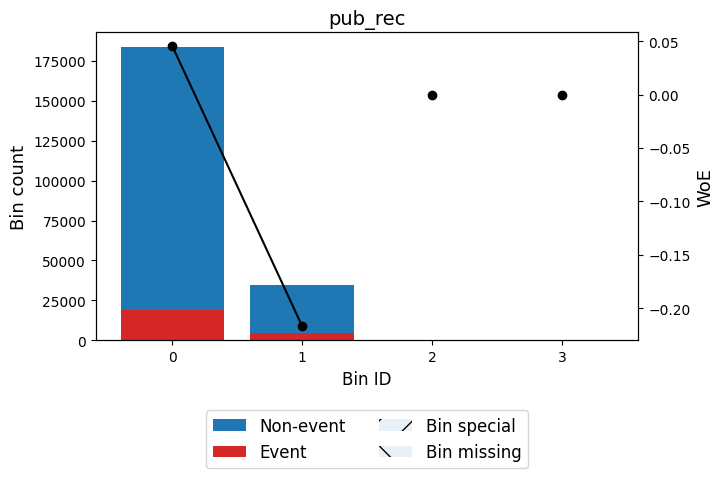


🔍 Feature: revol_util
✅ Total IV for revol_util: 0.0479
╒════════════════╤═════════╤════════════════════╤═══════════════════════╤═════════════╕
│ Bin            │   Count │   Default Rate (%) │ WOE                   │          IV │
╞════════════════╪═════════╪════════════════════╪═══════════════════════╪═════════════╡
│ (-inf, 13.95)  │   17062 │             0.0685 │ 0.49969344534061433   │ 0.0160641   │
├────────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ [13.95, 27.15) │   26410 │             0.0774 │ 0.3678550922777921    │ 0.0141885   │
├────────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ [27.15, 33.95) │   17734 │             0.0954 │ 0.13899719768115748   │ 0.00148826  │
├────────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ [33.95, 38.55) │   13127 │             0.0996 │ 0.09110322756452893   │ 0.000482244 │
├────────────────┼─────────┼────────────────────┼──────────────

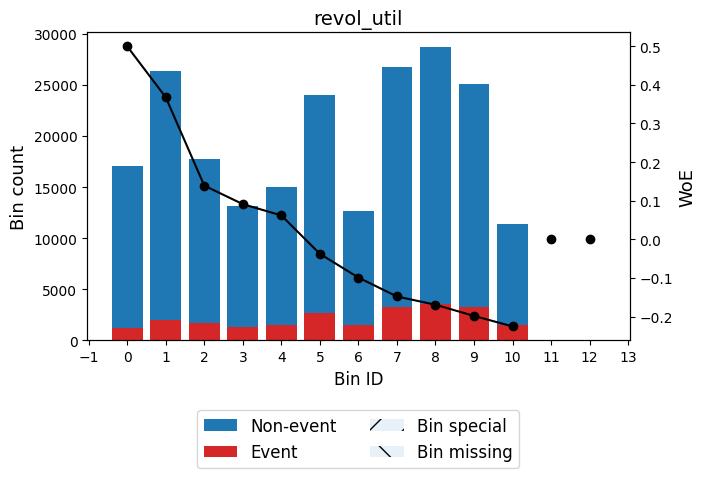


🔍 Feature: collections_12_mths_ex_med
✅ Total IV for collections_12_mths_ex_med: 0.0000
╒═════════════╤═════════╤════════════════════╤═══════════════════════╤══════╕
│ Bin         │   Count │   Default Rate (%) │ WOE                   │   IV │
╞═════════════╪═════════╪════════════════════╪═══════════════════════╪══════╡
│ (-inf, inf) │  217991 │              0.108 │ 4.440892098500626e-16 │    0 │
├─────────────┼─────────┼────────────────────┼───────────────────────┼──────┤
│ Special     │       0 │              0     │ 0.0                   │    0 │
├─────────────┼─────────┼────────────────────┼───────────────────────┼──────┤
│ Missing     │       0 │              0     │ 0.0                   │    0 │
├─────────────┼─────────┼────────────────────┼───────────────────────┼──────┤
│             │  217991 │              0.108 │                       │    0 │
╘═════════════╧═════════╧════════════════════╧═══════════════════════╧══════╛


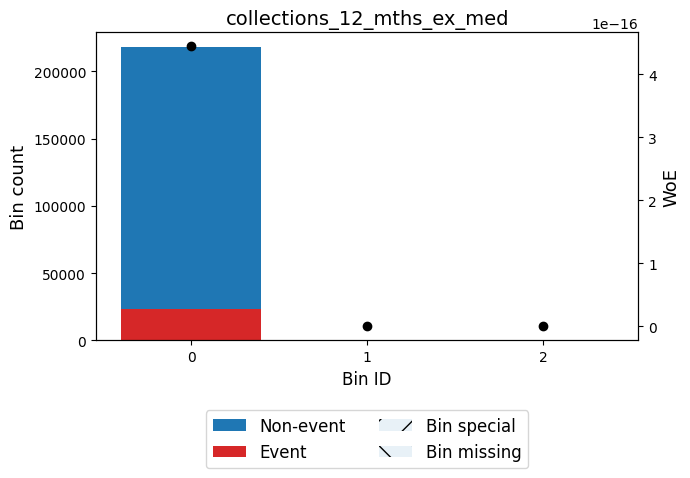


🔍 Feature: acc_now_delinq
✅ Total IV for acc_now_delinq: 0.0000
╒═════════════╤═════════╤════════════════════╤═══════════════════════╤══════╕
│ Bin         │   Count │   Default Rate (%) │ WOE                   │   IV │
╞═════════════╪═════════╪════════════════════╪═══════════════════════╪══════╡
│ (-inf, inf) │  217991 │              0.108 │ 4.440892098500626e-16 │    0 │
├─────────────┼─────────┼────────────────────┼───────────────────────┼──────┤
│ Special     │       0 │              0     │ 0.0                   │    0 │
├─────────────┼─────────┼────────────────────┼───────────────────────┼──────┤
│ Missing     │       0 │              0     │ 0.0                   │    0 │
├─────────────┼─────────┼────────────────────┼───────────────────────┼──────┤
│             │  217991 │              0.108 │                       │    0 │
╘═════════════╧═════════╧════════════════════╧═══════════════════════╧══════╛


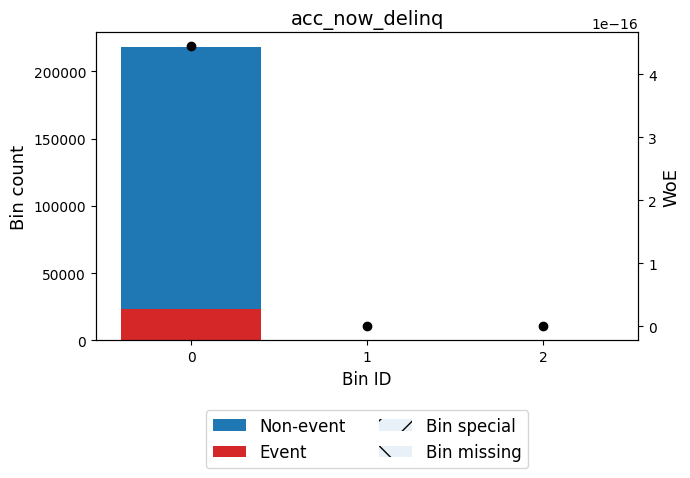


🔍 Feature: total_rev_hi_lim
✅ Total IV for total_rev_hi_lim: 0.0462
╒══════════════════════╤═════════╤════════════════════╤═══════════════════════╤═════════════╕
│ Bin                  │   Count │   Default Rate (%) │ WOE                   │          IV │
╞══════════════════════╪═════════╪════════════════════╪═══════════════════════╪═════════════╡
│ (-inf, 6544.50)      │   12260 │             0.1149 │ -0.06957834104981098  │ 0.000279788 │
├──────────────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ [6544.50, 25228.00)  │   91435 │             0.1216 │ -0.13384661065011638  │ 0.00791788  │
├──────────────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ [25228.00, 27405.00) │   15445 │             0.1345 │ -0.2490161033722209   │ 0.00484095  │
├──────────────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ [27405.00, 32925.00) │   19204 │             0.1091 │ -0.010904262302927847 │ 1.051

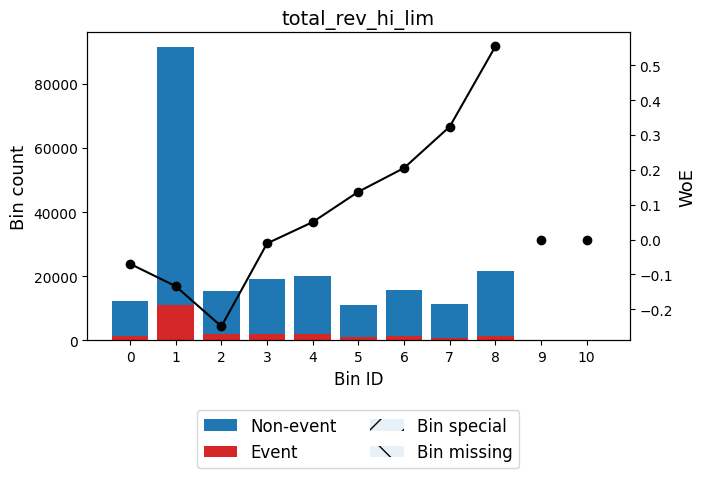


🔍 Feature: acc_open_past_24mths
✅ Total IV for acc_open_past_24mths: 0.0986
╒══════════════╤═════════╤════════════════════╤══════════════════════╤═════════════╕
│ Bin          │   Count │   Default Rate (%) │ WOE                  │          IV │
╞══════════════╪═════════╪════════════════════╪══════════════════════╪═════════════╡
│ (-inf, 1.50) │   31056 │             0.0678 │ 0.5093151765146797   │ 0.0302628   │
├──────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [1.50, 2.50) │   29566 │             0.0778 │ 0.3613046675534579   │ 0.0153628   │
├──────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [2.50, 3.50) │   32035 │             0.0898 │ 0.2054078233694696   │ 0.00571979  │
├──────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [3.50, 4.50) │   34234 │             0.1098 │ -0.01820163898604399 │ 5.24008e-05 │
├──────────────┼─────────┼────────────────────┼──────────────────────┼───

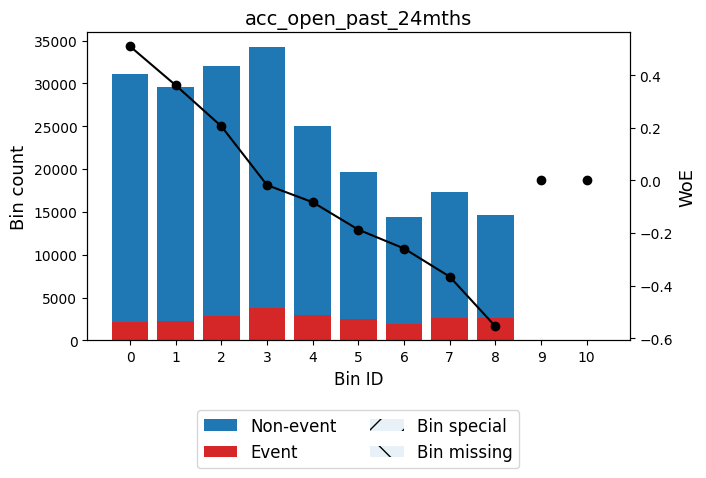


🔍 Feature: bc_open_to_buy
✅ Total IV for bc_open_to_buy: 0.0992
╒══════════════════════╤═════════╤════════════════════╤═══════════════════════╤═════════════╕
│ Bin                  │   Count │   Default Rate (%) │ WOE                   │          IV │
╞══════════════════════╪═════════╪════════════════════╪═══════════════════════╪═════════════╡
│ (-inf, 185.50)       │   11008 │             0.1508 │ -0.3826105354631786   │ 0.00857384  │
├──────────────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ [185.50, 553.50)     │   13513 │             0.1402 │ -0.29761856873538717  │ 0.00616445  │
├──────────────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ [553.50, 1450.50)    │   22040 │             0.1356 │ -0.25877463943984136  │ 0.00748822  │
├──────────────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ [1450.50, 2394.50)   │   17742 │             0.1304 │ -0.2137489381968416   │ 0.0040417

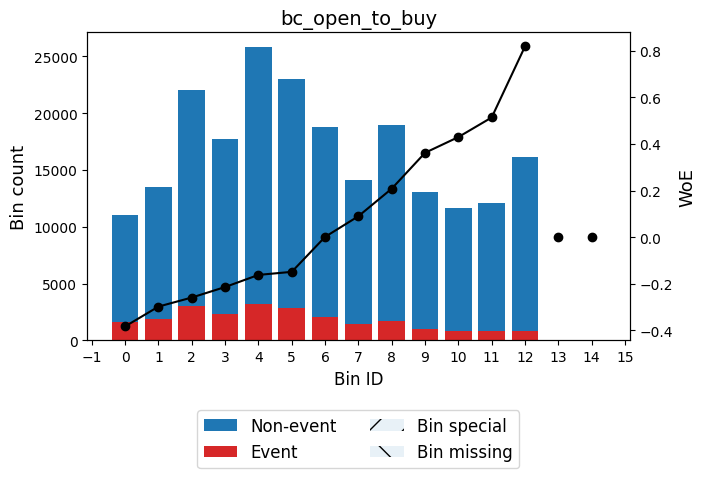


🔍 Feature: chargeoff_within_12_mths
✅ Total IV for chargeoff_within_12_mths: 0.0000
╒═════════════╤═════════╤════════════════════╤═══════════════════════╤══════╕
│ Bin         │   Count │   Default Rate (%) │ WOE                   │   IV │
╞═════════════╪═════════╪════════════════════╪═══════════════════════╪══════╡
│ (-inf, inf) │  217991 │              0.108 │ 4.440892098500626e-16 │    0 │
├─────────────┼─────────┼────────────────────┼───────────────────────┼──────┤
│ Special     │       0 │              0     │ 0.0                   │    0 │
├─────────────┼─────────┼────────────────────┼───────────────────────┼──────┤
│ Missing     │       0 │              0     │ 0.0                   │    0 │
├─────────────┼─────────┼────────────────────┼───────────────────────┼──────┤
│             │  217991 │              0.108 │                       │    0 │
╘═════════════╧═════════╧════════════════════╧═══════════════════════╧══════╛


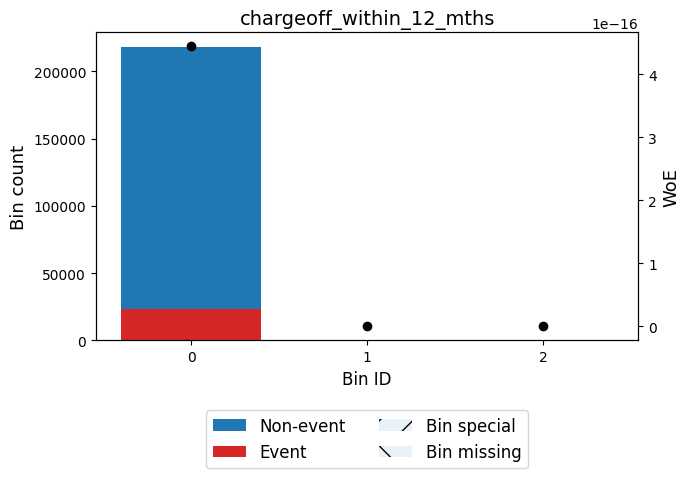


🔍 Feature: delinq_amnt
✅ Total IV for delinq_amnt: 0.0000
╒═════════════╤═════════╤════════════════════╤═══════════════════════╤══════╕
│ Bin         │   Count │   Default Rate (%) │ WOE                   │   IV │
╞═════════════╪═════════╪════════════════════╪═══════════════════════╪══════╡
│ (-inf, inf) │  217991 │              0.108 │ 4.440892098500626e-16 │    0 │
├─────────────┼─────────┼────────────────────┼───────────────────────┼──────┤
│ Special     │       0 │              0     │ 0.0                   │    0 │
├─────────────┼─────────┼────────────────────┼───────────────────────┼──────┤
│ Missing     │       0 │              0     │ 0.0                   │    0 │
├─────────────┼─────────┼────────────────────┼───────────────────────┼──────┤
│             │  217991 │              0.108 │                       │    0 │
╘═════════════╧═════════╧════════════════════╧═══════════════════════╧══════╛


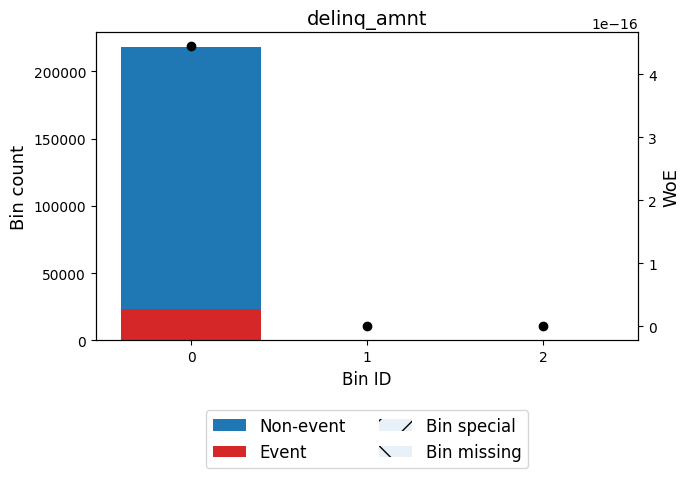


🔍 Feature: mo_sin_old_il_acct
✅ Total IV for mo_sin_old_il_acct: 0.0067
╒══════════════════╤═════════╤════════════════════╤═══════════════════════╤═════════════╕
│ Bin              │   Count │   Default Rate (%) │ WOE                   │          IV │
╞══════════════════╪═════════╪════════════════════╪═══════════════════════╪═════════════╡
│ (-inf, 37.50)    │   13083 │             0.1153 │ -0.07289201938480483  │ 0.00032811  │
├──────────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ [37.50, 131.50)  │  105659 │             0.1131 │ -0.05196407291405292  │ 0.00133571  │
├──────────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ [131.50, 139.50) │   18676 │             0.1117 │ -0.037403602147565884 │ 0.000121628 │
├──────────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ [139.50, 144.50) │   11020 │             0.1028 │ 0.05539643109778858   │ 0.000151799 │
├──────────────────┼───────

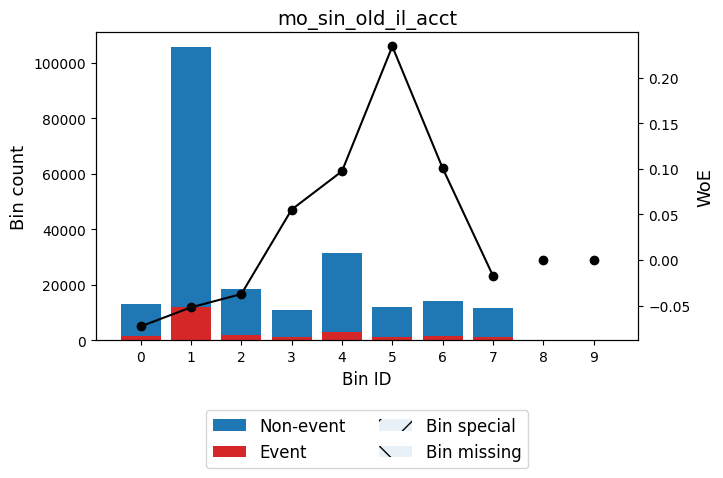


🔍 Feature: mo_sin_rcnt_rev_tl_op
✅ Total IV for mo_sin_rcnt_rev_tl_op: 0.0483
╒════════════════╤═════════╤════════════════════╤═══════════════════════╤═════════════╕
│ Bin            │   Count │   Default Rate (%) │ WOE                   │          IV │
╞════════════════╪═════════╪════════════════════╪═══════════════════════╪═════════════╡
│ (-inf, 1.50)   │   16427 │             0.1392 │ -0.28918860434355564  │ 0.00705237  │
├────────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ [1.50, 2.50)   │   16194 │             0.1267 │ -0.18062118389781245  │ 0.0026006   │
├────────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ [2.50, 3.50)   │   15489 │             0.1261 │ -0.17496919880201278  │ 0.00232903  │
├────────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ [3.50, 4.50)   │   14218 │             0.121  │ -0.12771100908980992  │ 0.00111825  │
├────────────────┼─────────┼─────────────

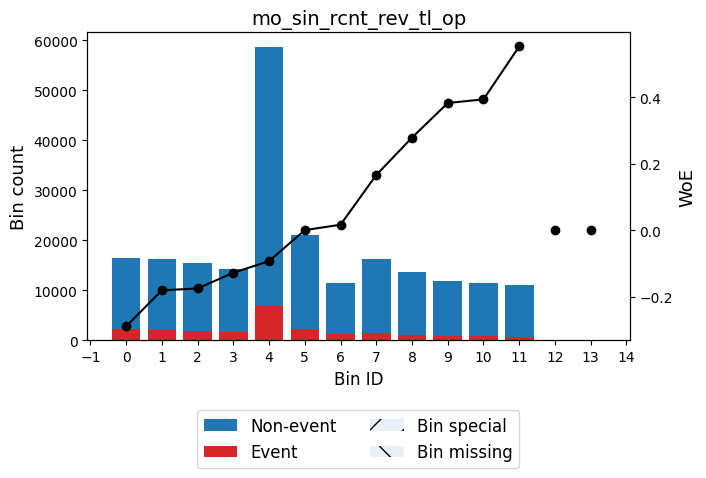


🔍 Feature: mo_sin_rcnt_tl
✅ Total IV for mo_sin_rcnt_tl: 0.0551
╒════════════════╤═════════╤════════════════════╤══════════════════════╤═════════════╕
│ Bin            │   Count │   Default Rate (%) │ WOE                  │          IV │
╞════════════════╪═════════╪════════════════════╪══════════════════════╪═════════════╡
│ (-inf, 1.50)   │   20653 │             0.1381 │ -0.27972121682809203 │ 0.00826543  │
├────────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [1.50, 3.50)   │   44554 │             0.1272 │ -0.18475303143650867 │ 0.00749807  │
├────────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [3.50, 4.50)   │   19666 │             0.1158 │ -0.07797631445300901 │ 0.000565531 │
├────────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [4.50, 6.50)   │   38304 │             0.1153 │ -0.0728727058729195  │ 0.000960115 │
├────────────────┼─────────┼────────────────────┼────────────────

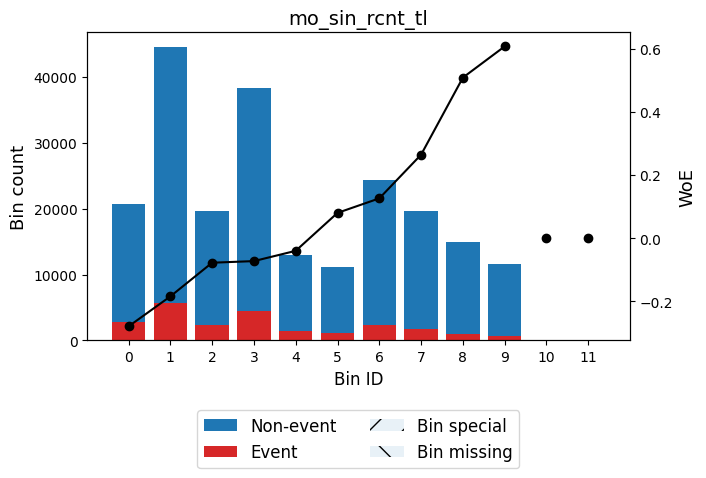


🔍 Feature: mort_acc
✅ Total IV for mort_acc: 0.0079
╒══════════════╤═════════╤════════════════════╤═══════════════════════╤═════════════╕
│ Bin          │   Count │   Default Rate (%) │ WOE                   │          IV │
╞══════════════╪═════════╪════════════════════╪═══════════════════════╪═════════════╡
│ (-inf, 0.50) │   89167 │             0.1164 │ -0.08408821887434614  │ 0.00298901  │
├──────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ [0.50, 1.50) │   42519 │             0.1112 │ -0.032624596071679335 │ 0.000210274 │
├──────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ [1.50, 2.50) │   31702 │             0.0995 │ 0.09196004279663628   │ 0.00118624  │
├──────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ [2.50, 3.50) │   22400 │             0.0971 │ 0.11893544863256977   │ 0.00138725  │
├──────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│

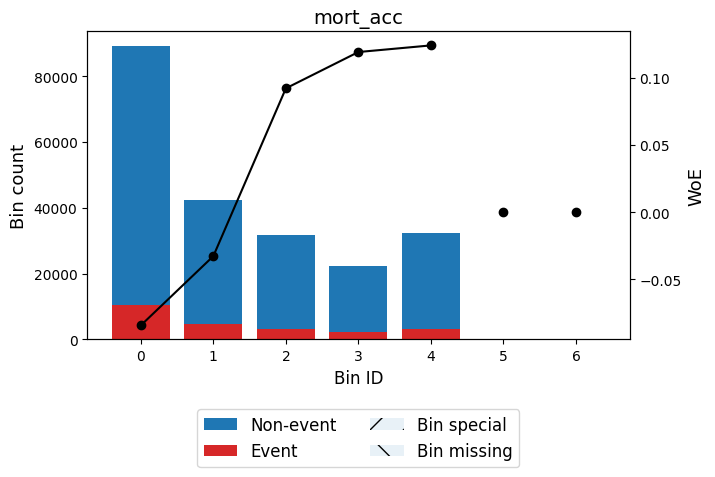


🔍 Feature: mths_since_recent_bc
✅ Total IV for mths_since_recent_bc: 0.0342
╒════════════════╤═════════╤════════════════════╤══════════════════════╤═════════════╕
│ Bin            │   Count │   Default Rate (%) │ WOE                  │          IV │
╞════════════════╪═════════╪════════════════════╪══════════════════════╪═════════════╡
│ (-inf, 3.50)   │   27927 │             0.1345 │ -0.24915634365418615 │ 0.00876353  │
├────────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [3.50, 5.50)   │   18694 │             0.1226 │ -0.142479508312348   │ 0.00184056  │
├────────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [5.50, 8.50)   │   24062 │             0.1197 │ -0.11598825246186828 │ 0.00155388  │
├────────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [8.50, 16.50)  │   54338 │             0.1156 │ -0.076096746856126   │ 0.00148707  │
├────────────────┼─────────┼────────────────────┼────

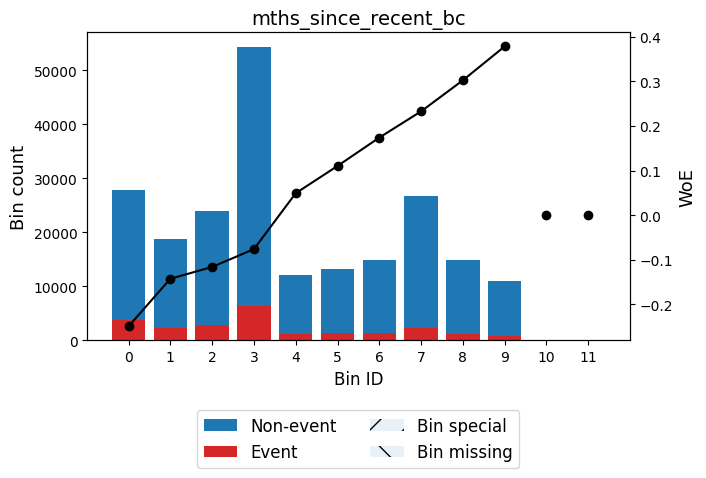


🔍 Feature: mths_since_recent_inq
✅ Total IV for mths_since_recent_inq: 0.0427
╒════════════════╤═════════╤════════════════════╤═══════════════════════╤═════════════╕
│ Bin            │   Count │   Default Rate (%) │ WOE                   │          IV │
╞════════════════╪═════════╪════════════════════╪═══════════════════════╪═════════════╡
│ (-inf, 0.50)   │   16331 │             0.146  │ -0.34447066759788414  │ 0.0101612   │
├────────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ [0.50, 1.50)   │   20266 │             0.1391 │ -0.288169847805549    │ 0.00863593  │
├────────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ [1.50, 2.50)   │   16553 │             0.1275 │ -0.1874334291402837   │ 0.00287013  │
├────────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ [2.50, 3.50)   │   15054 │             0.1252 │ -0.1670175879432294   │ 0.00205619  │
├────────────────┼─────────┼─────────────

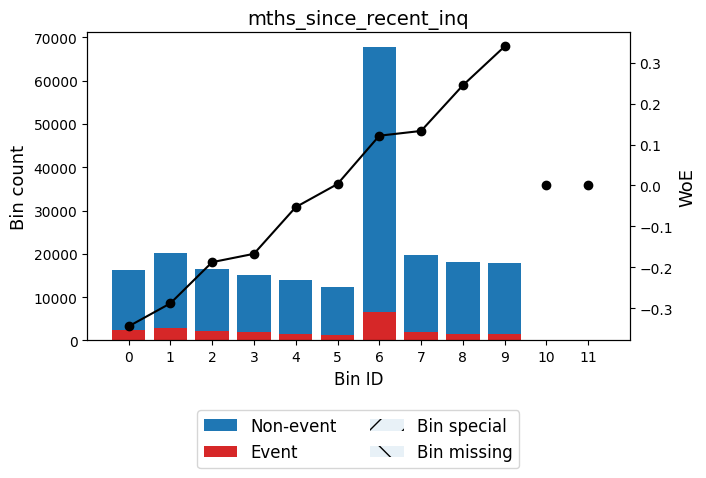


🔍 Feature: num_accts_ever_120_pd
✅ Total IV for num_accts_ever_120_pd: 0.0048
╒══════════════╤═════════╤════════════════════╤══════════════════════╤═════════════╕
│ Bin          │   Count │   Default Rate (%) │ WOE                  │          IV │
╞══════════════╪═════════╪════════════════════╪══════════════════════╪═════════════╡
│ (-inf, 0.50) │  169461 │             0.1045 │ 0.03766075893541743  │ 0.00108641  │
├──────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [0.50, 1.50) │   26010 │             0.1233 │ -0.14904344478936404 │ 0.00280943  │
├──────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [1.50, inf)  │   22520 │             0.1174 │ -0.09330670098502836 │ 0.000932845 │
├──────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ Special      │       0 │             0      │ 0.0                  │ 0           │
├──────────────┼─────────┼────────────────────┼──────────────────────┼─

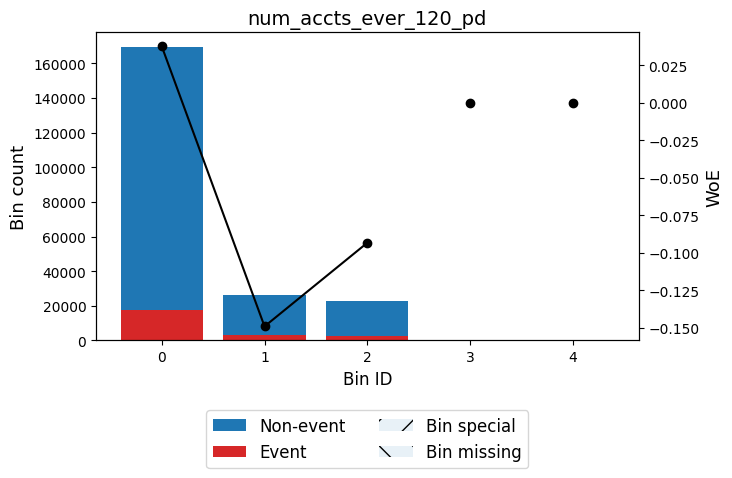


🔍 Feature: num_bc_tl
✅ Total IV for num_bc_tl: 0.0076
╒════════════════╤═════════╤════════════════════╤══════════════════════╤═════════════╕
│ Bin            │   Count │   Default Rate (%) │ WOE                  │          IV │
╞════════════════╪═════════╪════════════════════╪══════════════════════╪═════════════╡
│ (-inf, 2.50)   │   16552 │             0.0945 │ 0.14904788903698307  │ 0.00159091  │
├────────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [2.50, 3.50)   │   17572 │             0.0963 │ 0.12819384486361995  │ 0.00125968  │
├────────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [3.50, 4.50)   │   21522 │             0.1002 │ 0.08430894837125047  │ 0.000678927 │
├────────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [4.50, 5.50)   │   22089 │             0.1005 │ 0.08019750256147562  │ 0.000631527 │
├────────────────┼─────────┼────────────────────┼──────────────────────┼───

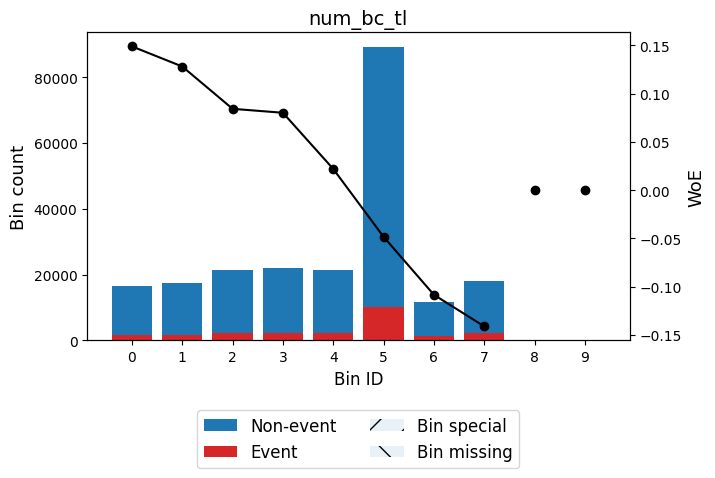


🔍 Feature: num_il_tl
✅ Total IV for num_il_tl: 0.0074
╒════════════════╤═════════╤════════════════════╤═══════════════════════╤═════════════╕
│ Bin            │   Count │   Default Rate (%) │ WOE                   │          IV │
╞════════════════╪═════════╪════════════════════╪═══════════════════════╪═════════════╡
│ (-inf, 1.50)   │   18979 │             0.0951 │ 0.14249306669664286   │ 0.00167157  │
├────────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ [1.50, 2.50)   │   16495 │             0.0985 │ 0.10288259491902485   │ 0.000769237 │
├────────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ [2.50, 3.50)   │   18240 │             0.0998 │ 0.08809805031308171   │ 0.000627341 │
├────────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ [3.50, 6.50)   │   52310 │             0.1031 │ 0.051909505260576694  │ 0.000633573 │
├────────────────┼─────────┼────────────────────┼────────────────

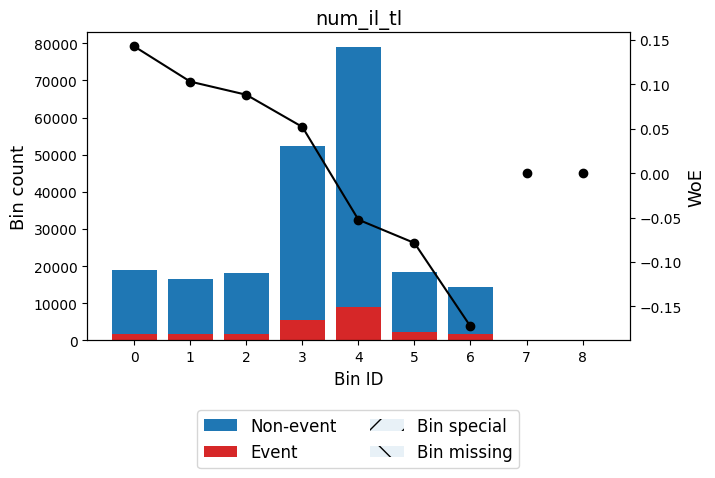


🔍 Feature: num_tl_120dpd_2m
✅ Total IV for num_tl_120dpd_2m: 0.0000
╒═════════════╤═════════╤════════════════════╤═══════════════════════╤══════╕
│ Bin         │   Count │   Default Rate (%) │ WOE                   │   IV │
╞═════════════╪═════════╪════════════════════╪═══════════════════════╪══════╡
│ (-inf, inf) │  217991 │              0.108 │ 4.440892098500626e-16 │    0 │
├─────────────┼─────────┼────────────────────┼───────────────────────┼──────┤
│ Special     │       0 │              0     │ 0.0                   │    0 │
├─────────────┼─────────┼────────────────────┼───────────────────────┼──────┤
│ Missing     │       0 │              0     │ 0.0                   │    0 │
├─────────────┼─────────┼────────────────────┼───────────────────────┼──────┤
│             │  217991 │              0.108 │                       │    0 │
╘═════════════╧═════════╧════════════════════╧═══════════════════════╧══════╛


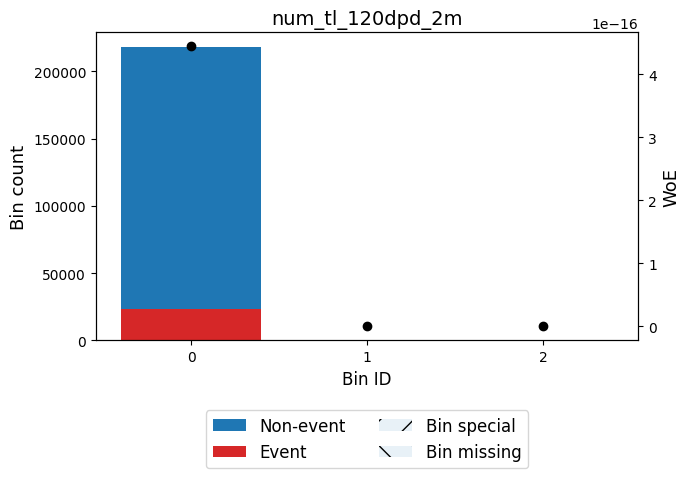


🔍 Feature: num_tl_90g_dpd_24m
✅ Total IV for num_tl_90g_dpd_24m: 0.0030
╒══════════════╤═════════╤════════════════════╤══════════════════════╤═════════════╕
│ Bin          │   Count │   Default Rate (%) │ WOE                  │          IV │
╞══════════════╪═════════╪════════════════════╪══════════════════════╪═════════════╡
│ (-inf, 0.50) │  206775 │             0.1068 │ 0.013382506253671878 │ 0.000168988 │
├──────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [0.50, inf)  │   11216 │             0.1317 │ -0.22482991034151878 │ 0.00283905  │
├──────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ Special      │       0 │             0      │ 0.0                  │ 0           │
├──────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ Missing      │       0 │             0      │ 0.0                  │ 0           │
├──────────────┼─────────┼────────────────────┼──────────────────────┼───────

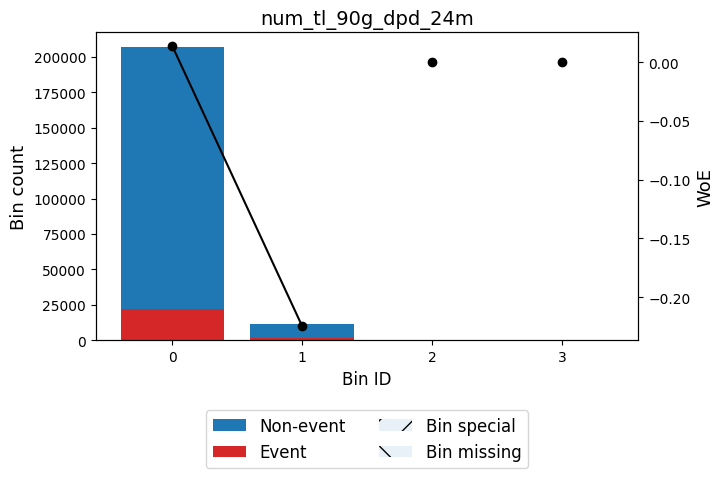


🔍 Feature: num_tl_op_past_12m
✅ Total IV for num_tl_op_past_12m: 0.0815
╒══════════════╤═════════╤════════════════════╤═══════════════════════╤═════════════╕
│ Bin          │   Count │   Default Rate (%) │ WOE                   │          IV │
╞══════════════╪═════════╪════════════════════╪═══════════════════════╪═════════════╡
│ (-inf, 0.50) │   40164 │             0.0715 │ 0.453189890567423     │ 0.031674    │
├──────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ [0.50, 1.50) │   54174 │             0.0883 │ 0.22328635265773844   │ 0.0113497   │
├──────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ [1.50, 2.50) │   53091 │             0.1111 │ -0.031513808091502504 │ 0.000244876 │
├──────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ [2.50, 3.50) │   32354 │             0.1302 │ -0.2116298216770034   │ 0.00721918  │
├──────────────┼─────────┼────────────────────┼────────────────────

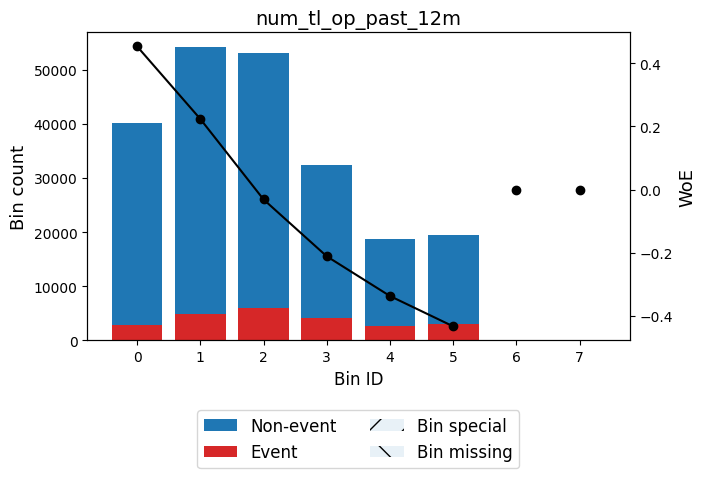


🔍 Feature: pct_tl_nvr_dlq
✅ Total IV for pct_tl_nvr_dlq: 0.0006
╒═══════════════╤═════════╤════════════════════╤═══════════════════════╤═════════════╕
│ Bin           │   Count │   Default Rate (%) │ WOE                   │          IV │
╞═══════════════╪═════════╪════════════════════╪═══════════════════════╪═════════════╡
│ (-inf, 75.20) │   11054 │             0.0982 │ 0.10694494127680576   │ 0.000556123 │
├───────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ [75.20, inf)  │  206937 │             0.1086 │ -0.005466135436267727 │ 2.84244e-05 │
├───────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ Special       │       0 │             0      │ 0.0                   │ 0           │
├───────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ Missing       │       0 │             0      │ 0.0                   │ 0           │
├───────────────┼─────────┼────────────────────┼─────────────────

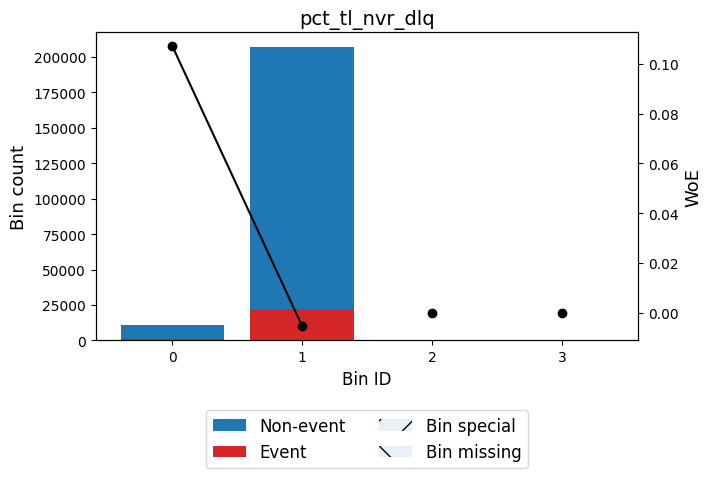


🔍 Feature: tot_hi_cred_lim
✅ Total IV for tot_hi_cred_lim: 0.0402
╒════════════════════════╤═════════╤════════════════════╤═══════════════════════╤═════════════╕
│ Bin                    │   Count │   Default Rate (%) │ WOE                   │          IV │
╞════════════════════════╪═════════╪════════════════════╪═══════════════════════╪═════════════╡
│ (-inf, 20291.50)       │   11684 │             0.1041 │ 0.041800851352586044  │ 9.21304e-05 │
├────────────────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ [20291.50, 36512.50)   │   20673 │             0.1199 │ -0.11771873342452155  │ 0.00137609  │
├────────────────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ [36512.50, 112547.00)  │   71947 │             0.1227 │ -0.14399111733324022  │ 0.00723905  │
├────────────────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ [112547.00, 126145.00) │   12936 │             0.1353 │ -0.25590814

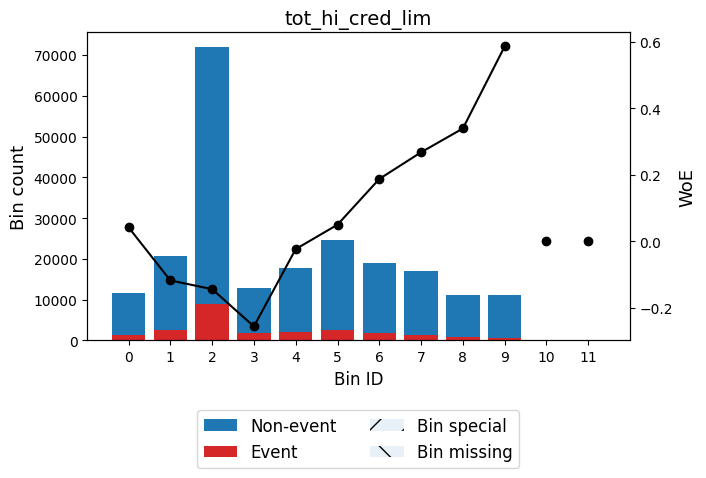


🔍 Feature: total_bal_ex_mort
✅ Total IV for total_bal_ex_mort: 0.0113
╒═══════════════════════╤═════════╤════════════════════╤═══════════════════════╤═════════════╕
│ Bin                   │   Count │   Default Rate (%) │ WOE                   │          IV │
╞═══════════════════════╪═════════╪════════════════════╪═══════════════════════╪═════════════╡
│ (-inf, 10630.50)      │   20935 │             0.0862 │ 0.250348284589474     │ 0.00545522  │
├───────────────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ [10630.50, 21739.50)  │   34651 │             0.1023 │ 0.06122149173007818   │ 0.00058164  │
├───────────────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ [21739.50, 29885.50)  │   26561 │             0.1128 │ -0.048470855050617434 │ 0.00029175  │
├───────────────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ [29885.50, 37488.50)  │   22851 │             0.1155 │ -0.07507891986286

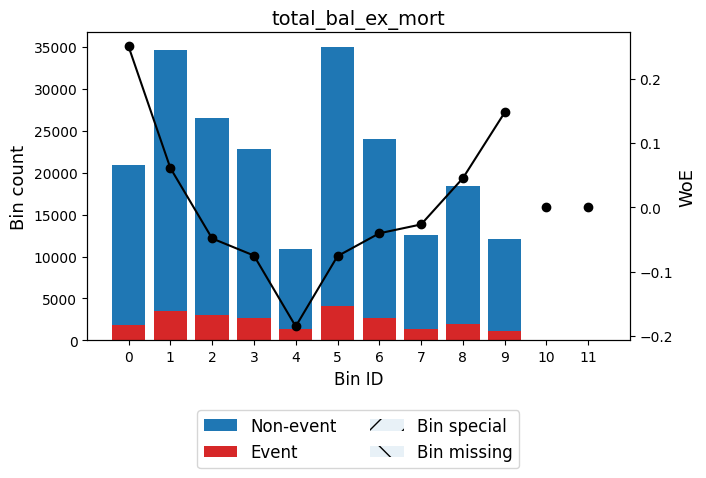


🔍 Feature: credit_history_years
✅ Total IV for credit_history_years: 0.0097
╒════════════════╤═════════╤════════════════════╤═══════════════════════╤═════════════╕
│ Bin            │   Count │   Default Rate (%) │ WOE                   │          IV │
╞════════════════╪═════════╪════════════════════╪═══════════════════════╪═════════════╡
│ (-inf, 6.54)   │   13284 │             0.0998 │ 0.0882782689237036    │ 0.000458725 │
├────────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ [6.54, 8.46)   │   10976 │             0.1152 │ -0.0718744111788614   │ 0.00026753  │
├────────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ [8.46, 10.21)  │   14721 │             0.1268 │ -0.18101961147863754  │ 0.00237486  │
├────────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ [10.21, 11.46) │   17229 │             0.124  │ -0.15619352400628506  │ 0.00204949  │
├────────────────┼─────────┼───────────────

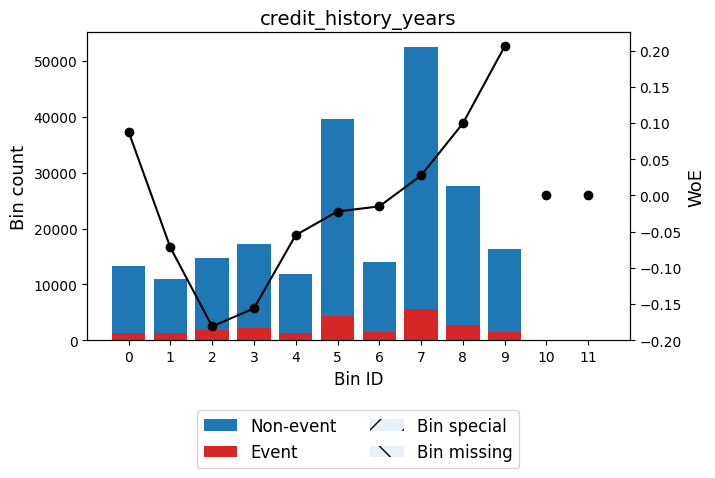


🔍 Feature: fico_score
✅ Total IV for fico_score: 0.1582
╒══════════════════╤═════════╤════════════════════╤══════════════════════╤═════════════╕
│ Bin              │   Count │   Default Rate (%) │ WOE                  │          IV │
╞══════════════════╪═════════╪════════════════════╪══════════════════════╪═════════════╡
│ (-inf, 664.50)   │   17676 │             0.152  │ -0.39206408065623366 │ 0.0145082   │
├──────────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [664.50, 669.50) │   17177 │             0.1482 │ -0.36187508868525975 │ 0.0118736   │
├──────────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [669.50, 674.50) │   17577 │             0.146  │ -0.344520350286744   │ 0.0109398   │
├──────────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [674.50, 679.50) │   15831 │             0.135  │ -0.2534005454094779  │ 0.00514691  │
├──────────────────┼─────────┼────────────────────┼──

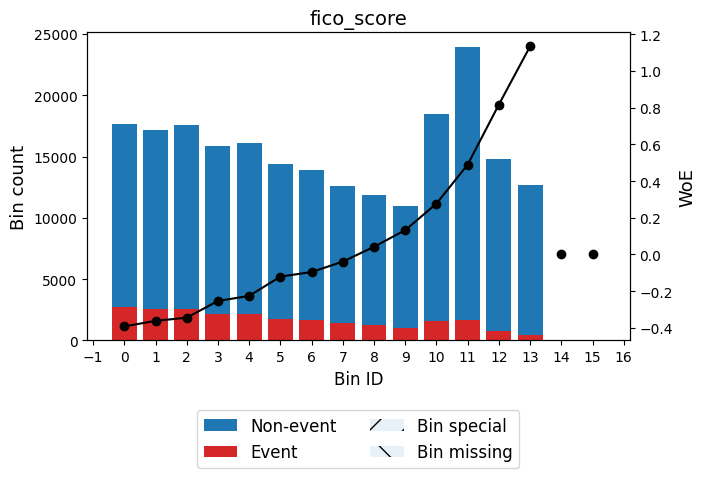


🔍 Feature: proportion_satisfac_accounts
✅ Total IV for proportion_satisfac_accounts: 0.0121
╒══════════════╤═════════╤════════════════════╤════════════════════════╤═════════════╕
│ Bin          │   Count │   Default Rate (%) │ WOE                    │          IV │
╞══════════════╪═════════╪════════════════════╪════════════════════════╪═════════════╡
│ (-inf, 0.81) │   13344 │             0.0857 │ 0.2559497090102667     │ 0.00362652  │
├──────────────┼─────────┼────────────────────┼────────────────────────┼─────────────┤
│ [0.81, 0.84) │   10927 │             0.088  │ 0.22686443220985053    │ 0.00235989  │
├──────────────┼─────────┼────────────────────┼────────────────────────┼─────────────┤
│ [0.84, 0.86) │   14647 │             0.0941 │ 0.1530411725023031     │ 0.00148193  │
├──────────────┼─────────┼────────────────────┼────────────────────────┼─────────────┤
│ [0.86, 0.88) │   16318 │             0.1017 │ 0.06788412032824809    │ 0.00033589  │
├──────────────┼─────────┼───────────

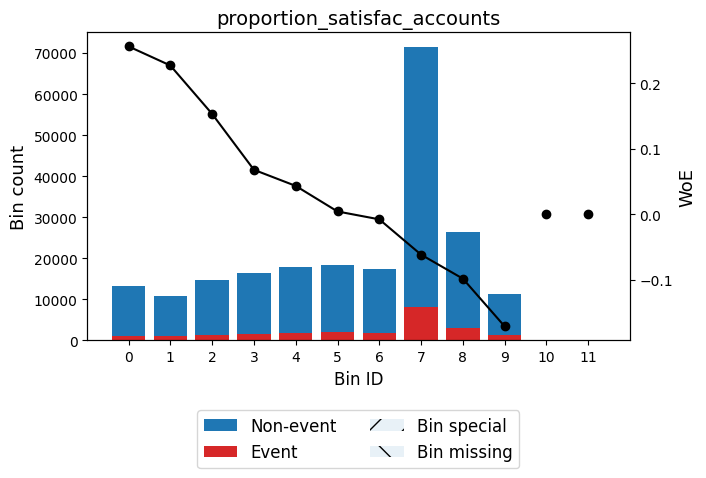


🔍 Feature: proportion_satisfac_bc_tl
✅ Total IV for proportion_satisfac_bc_tl: 0.0103
╒══════════════╤═════════╤════════════════════╤═══════════════════════╤═════════════╕
│ Bin          │   Count │   Default Rate (%) │ WOE                   │          IV │
╞══════════════╪═════════╪════════════════════╪═══════════════════════╪═════════════╡
│ (-inf, 0.74) │   37966 │             0.105  │ 0.032308882873169686  │ 0.000179514 │
├──────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ [0.74, 0.76) │   22848 │             0.1093 │ -0.013364849586120275 │ 1.88197e-05 │
├──────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ [0.76, 0.83) │   17320 │             0.1145 │ -0.06586735289067569  │ 0.000353711 │
├──────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ [0.83, 0.93) │   25797 │             0.1235 │ -0.15092689998242048  │ 0.00285938  │
├──────────────┼─────────┼────────────────────┼──────

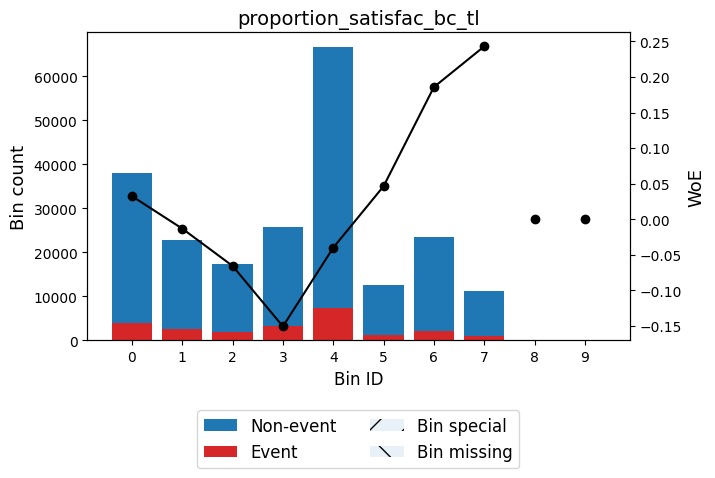

In [8]:
# =======================================
# === Get WoE trend for each variable ===
# =======================================

numerical_cols = get_numerical_cols(df, TARGET_COL)

for feature in numerical_cols:
    if feature == "id":
        continue

    print(f"\n🔍 Feature: {feature}")
    sample_df = (
        df.select(feature, TARGET_COL)
        .sample(fraction=SAMPLE_FRAC, seed=SEED)
        .toPandas()
    )

    if sample_df[feature].nunique() < 2:
        print("⚠️ Not enough variation. Skipping.")
        iv_categories["no_variation"].append(feature)
        continue

    x, y = sample_df[feature], sample_df[TARGET_COL]
    first_bin_and_classify_feature(feature=feature, x=x, y=y, monotonic_trend_type='auto')

In [9]:
# ==============================================
# Find useless vs weak vs no_variation features 
# ==============================================

for key, val in iv_categories.items():
    print(f"\n⚡️ {key.capitalize()}\n Features ({len(val)}):")
    for feature, iv in val:
        print(f" - {feature}: {iv:.4f}")


⚡️ Useless (< 0.02)
 Features (18):
 - delinq_2yrs: 0.0068
 - pub_rec: 0.0098
 - collections_12_mths_ex_med: 0.0000
 - acc_now_delinq: 0.0000
 - chargeoff_within_12_mths: 0.0000
 - delinq_amnt: 0.0000
 - mo_sin_old_il_acct: 0.0067
 - mort_acc: 0.0079
 - num_accts_ever_120_pd: 0.0048
 - num_bc_tl: 0.0076
 - num_il_tl: 0.0074
 - num_tl_120dpd_2m: 0.0000
 - num_tl_90g_dpd_24m: 0.0030
 - pct_tl_nvr_dlq: 0.0006
 - total_bal_ex_mort: 0.0113
 - credit_history_years: 0.0097
 - proportion_satisfac_accounts: 0.0121
 - proportion_satisfac_bc_tl: 0.0103

⚡️ Weak (< 0.1)
 Features (15):
 - loan_amnt: 0.0277
 - term: 0.0731
 - annual_inc: 0.0286
 - dti: 0.0540
 - inq_last_6mths: 0.0628
 - revol_util: 0.0479
 - total_rev_hi_lim: 0.0462
 - acc_open_past_24mths: 0.0986
 - bc_open_to_buy: 0.0992
 - mo_sin_rcnt_rev_tl_op: 0.0483
 - mo_sin_rcnt_tl: 0.0551
 - mths_since_recent_bc: 0.0342
 - mths_since_recent_inq: 0.0427
 - num_tl_op_past_12m: 0.0815
 - tot_hi_cred_lim: 0.0402

⚡️ Medium (< 0.3)
 Features 

From the results above, we can categorise situations of WoE monotonicity for our numerical features into the following gameplans. 

- **Monotonic WoE & Medium IV**: `fico_score`, `bc_open_to_buy` (Accepted)
- **Monotonic WoE & Weak IV**: `term`, `annual_inc`, `dti`, ... 🚩 (Accepted)
- **Non-Monotonic WoE & Weak IV**: Allow WoE constraint to be violated (since enforcing WoE Monotonicity on non-linear patterns may decrease Gini Coefficient)
- **Monotonic WoE & Useless IV**: Drop these variables (Unlikely to be helpful in predictive values, even when interaction features are created)
- **Non-Monotonic WoE & Useless IV**: Drop variables (`optbinning` has already attempted to optimise IV score. Non-monotonicity has already rendered best IV scores)

In [10]:
# =================
# Inspect IV score 
# =================

for key, value in iv_categories.items(): 
    print("👑 " + key.capitalize())
    
    for a_tuple in value: 
        print(a_tuple)
        
    print('\n################################\n')

👑 Useless (< 0.02)
('delinq_2yrs', np.float64(0.006762143980521645))
('pub_rec', np.float64(0.009782467672196097))
('collections_12_mths_ex_med', np.float64(0.0))
('acc_now_delinq', np.float64(0.0))
('chargeoff_within_12_mths', np.float64(0.0))
('delinq_amnt', np.float64(0.0))
('mo_sin_old_il_acct', np.float64(0.006667886616433656))
('mort_acc', np.float64(0.007931255732181569))
('num_accts_ever_120_pd', np.float64(0.004828682959684444))
('num_bc_tl', np.float64(0.007588933088295326))
('num_il_tl', np.float64(0.007374777416292187))
('num_tl_120dpd_2m', np.float64(0.0))
('num_tl_90g_dpd_24m', np.float64(0.0030080340689503313))
('pct_tl_nvr_dlq', np.float64(0.0005845470624135888))
('total_bal_ex_mort', np.float64(0.011270811148483977))
('credit_history_years', np.float64(0.009731113652143332))
('proportion_satisfac_accounts', np.float64(0.012058325285492577))
('proportion_satisfac_bc_tl', np.float64(0.01026338586727132))

################################

👑 Weak (< 0.1)
('loan_amnt', np.

In [11]:
# ============================================================================================================
# Domain Features (Rare but Strong predictors of Default) -> Transform into 1 relatively stronger predictor
# ============================================================================================================

domain_keep = ['delinq_2yrs', 'pub_rec', 'acc_now_delinq', 
               'chargeoff_within_12_mths', 'collections_12_mths_ex_med']

df = df.withColumn("any_derog_flag", when(
    (col("delinq_2yrs") >= 1) |
    (col("pub_rec") >= 1) |
    (col("acc_now_delinq") >= 1) |
    (col("chargeoff_within_12_mths") >= 1) |
    (col("collections_12_mths_ex_med") >= 1),
    1
).otherwise(0))




In [12]:
# ====================================
# Drop all useless numerical features 
# ====================================

useless_features_to_drop = []
for value in iv_categories.values(): 
    for feature, iv_score in value: 
        if iv_score < 0.02: 
            useless_features_to_drop.append(feature)
        

print("🗑️ Dropping useless features with IV < 0.02 ...")

for column in useless_features_to_drop: 
    if column in df.columns: 
        df = df.drop(column) 
        
df.limit(10).toPandas() 

🗑️ Dropping useless features with IV < 0.02 ...


,id,loan_amnt,term,grade,home_ownership,annual_inc,verification_status,issue_d,default_status,pymnt_plan,...,acc_open_past_24mths,bc_open_to_buy,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mths_since_recent_bc,mths_since_recent_inq,num_tl_op_past_12m,tot_hi_cred_lim,fico_score,any_derog_flag
0,14639393,20000.0,60,E,MORTGAGE,60000.0,Verified,2014-05-01,0,n,...,7.0,82.0,18.0,12.0,80.0,1.0,1.0,228569.0,672.0,0
1,14580137,20000.0,60,E,MORTGAGE,46962.0,Verified,2014-05-01,1,n,...,6.0,2088.0,1.0,1.0,1.0,1.0,3.0,250522.0,672.0,0
2,14490894,4800.0,36,B,OWN,30000.0,Verified,2014-05-01,0,n,...,6.0,1133.0,6.0,6.0,6.0,10.0,4.0,8300.0,677.0,1
3,14610358,10000.0,60,C,MORTGAGE,50000.0,Source Verified,2014-05-01,1,n,...,4.0,8462.0,5.0,5.0,5.0,10.0,3.0,268285.0,697.0,1
4,14699258,27000.0,60,C,OWN,60206.0,Verified,2014-05-01,0,n,...,4.0,3703.0,21.0,9.0,21.0,16.0,1.0,35596.0,697.0,0
5,14550710,8400.0,36,B,RENT,80000.0,Verified,2014-05-01,0,n,...,4.0,7072.0,4.0,4.0,11.0,4.0,2.0,17600.0,712.0,0
6,14499399,10000.0,36,B,RENT,70000.0,Source Verified,2014-05-01,0,n,...,1.0,723.0,25.0,1.0,25.0,1.0,1.0,101200.0,692.0,0
7,14460269,10800.0,60,C,RENT,35000.0,Source Verified,2014-05-01,0,n,...,1.0,6176.0,14.0,14.0,14.0,13.0,0.0,29200.0,697.0,0
8,14528766,20000.0,36,B,RENT,90000.0,Verified,2014-05-01,1,n,...,3.0,6737.0,10.0,1.0,10.0,1.0,2.0,50150.0,682.0,0
9,14580340,7800.0,36,B,MORTGAGE,35000.0,Source Verified,2014-05-01,1,n,...,9.0,3661.0,14.0,14.0,17.0,14.0,0.0,106462.0,702.0,1


### 1.1.2 Categorical Features WoE & IV Feature Selection

In [13]:
def get_categorical_cols(df): 
    """
    Get categorical columns from a Pyspark Dataframe & Return list of categorical columns 
    """
    
    return [column.name for column in df.schema.fields if isinstance(column.dataType, StringType)]
    
categorical_features = get_categorical_cols(df)

print(categorical_features) 

['grade', 'home_ownership', 'verification_status', 'pymnt_plan', 'initial_list_status', 'application_type']


- Ordinal Features: `grade`
- Nominal Features: `home_ownership`, `verification_status`, `pymnt_plan`, `initial_list_status`, `application_type`

In `optbinning` library, we will have to treat `grade` as a `dtype=numerical`. This ensures that `grade` is treated as an ordinal variable, in which this preserves natural ordering of risk across categories. Meanwhile, for the nominal features, they shall be treated as `dtype=categorical`. 

✅ Total IV for home_ownership: 0.0179
╒══════════════════════╤═════════╤════════════════════╤═════════════════════╤═════════════╕
│ Bin                  │   Count │   Default Rate (%) │ WOE                 │          IV │
╞══════════════════════╪═════════╪════════════════════╪═════════════════════╪═════════════╡
│ ['OTHER' 'MORTGAGE'] │   53746 │             0.0968 │ 0.12887035946941028 │ 0.00780087  │
├──────────────────────┼─────────┼────────────────────┼─────────────────────┼─────────────┤
│ ['OWN']              │   12175 │             0.1053 │ 0.03514194593157827 │ 0.000136325 │
├──────────────────────┼─────────┼────────────────────┼─────────────────────┼─────────────┤
│ ['RENT']             │   42864 │             0.1245 │ -0.1539460642574173 │ 0.00991597  │
├──────────────────────┼─────────┼────────────────────┼─────────────────────┼─────────────┤
│ Special              │       0 │             0      │ 0.0                 │ 0           │
├──────────────────────┼─────────┼────────

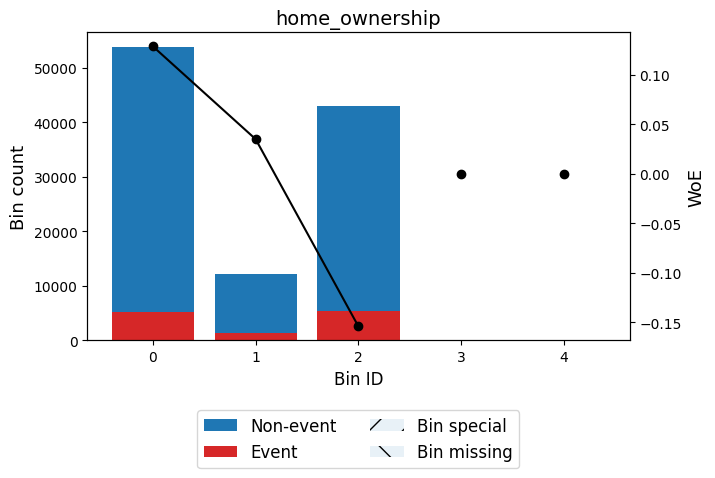

✅ Total IV for verification_status: 0.0907
╒═════════════════════╤═════════╤════════════════════╤═══════════════════════╤═════════════╕
│ Bin                 │   Count │   Default Rate (%) │ WOE                   │          IV │
╞═════════════════════╪═════════╪════════════════════╪═══════════════════════╪═════════════╡
│ ['Not Verified']    │   35994 │             0.0737 │ 0.42653971904818233   │ 0.050927    │
├─────────────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ ['Source Verified'] │   42721 │             0.1105 │ -0.018515199494161916 │ 0.000135605 │
├─────────────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ ['Verified']        │   30070 │             0.1479 │ -0.3535602761842911   │ 0.0396241   │
├─────────────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ Special             │       0 │             0      │ 0.0                   │ 0           │
├─────────────────────┼────

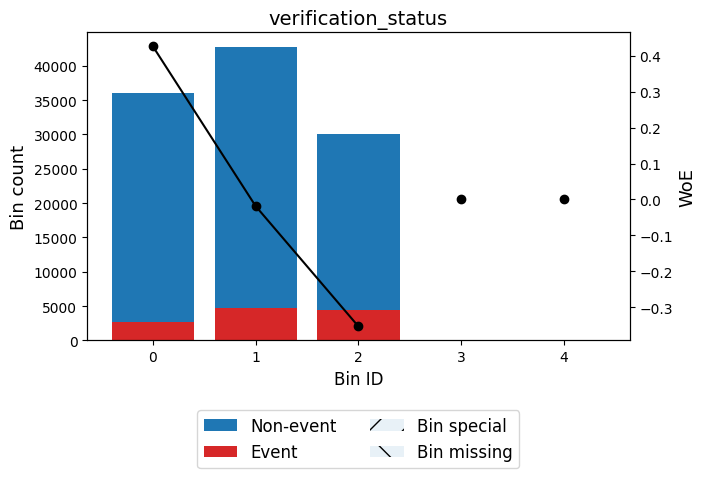

✅ Total IV for pymnt_plan: 0.0000
╒═════════╤═════════╤════════════════════╤═══════════════════════╤══════╕
│ Bin     │   Count │   Default Rate (%) │ WOE                   │   IV │
╞═════════╪═════════╪════════════════════╪═══════════════════════╪══════╡
│ ['n']   │  108785 │             0.1087 │ 4.440892098500626e-16 │    0 │
├─────────┼─────────┼────────────────────┼───────────────────────┼──────┤
│ Special │       0 │             0      │ 0.0                   │    0 │
├─────────┼─────────┼────────────────────┼───────────────────────┼──────┤
│ Missing │       0 │             0      │ 0.0                   │    0 │
├─────────┼─────────┼────────────────────┼───────────────────────┼──────┤
│         │  108785 │             0.1087 │                       │    0 │
╘═════════╧═════════╧════════════════════╧═══════════════════════╧══════╛


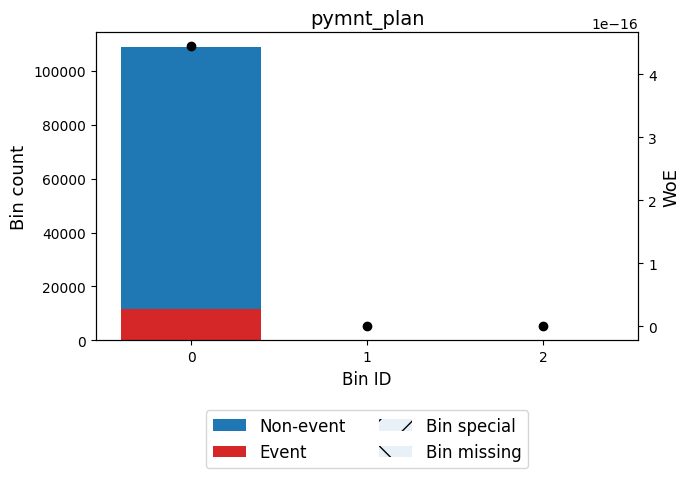

✅ Total IV for initial_list_status: 0.0445
╒═════════╤═════════╤════════════════════╤═════════════════════╤═══════════╕
│ Bin     │   Count │   Default Rate (%) │ WOE                 │        IV │
╞═════════╪═════════╪════════════════════╪═════════════════════╪═══════════╡
│ ['w']   │   74021 │             0.0943 │ 0.15785657195912917 │ 0.0159379 │
├─────────┼─────────┼────────────────────┼─────────────────────┼───────────┤
│ ['f']   │   34764 │             0.1393 │ -0.2830509721682912 │ 0.028578  │
├─────────┼─────────┼────────────────────┼─────────────────────┼───────────┤
│ Special │       0 │             0      │ 0.0                 │ 0         │
├─────────┼─────────┼────────────────────┼─────────────────────┼───────────┤
│ Missing │       0 │             0      │ 0.0                 │ 0         │
├─────────┼─────────┼────────────────────┼─────────────────────┼───────────┤
│         │  108785 │             0.1087 │                     │ 0.0445159 │
╘═════════╧═════════╧════════════

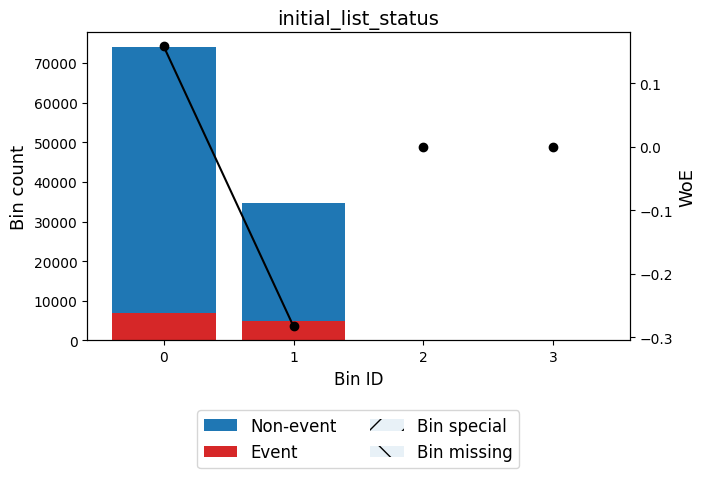

✅ Total IV for application_type: 0.0228
╒════════════════╤═════════╤════════════════════╤═══════════════════════╤═════════════╕
│ Bin            │   Count │   Default Rate (%) │ WOE                   │          IV │
╞════════════════╪═════════╪════════════════════╪═══════════════════════╪═════════════╡
│ ['Joint App']  │    5625 │             0.0542 │ 0.7543597290580268    │ 0.0219228   │
├────────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ ['Individual'] │  103160 │             0.1116 │ -0.030285192519089232 │ 0.000880131 │
├────────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ Special        │       0 │             0      │ 0.0                   │ 0           │
├────────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ Missing        │       0 │             0      │ 0.0                   │ 0           │
├────────────────┼─────────┼────────────────────┼───────────────────────┼───────

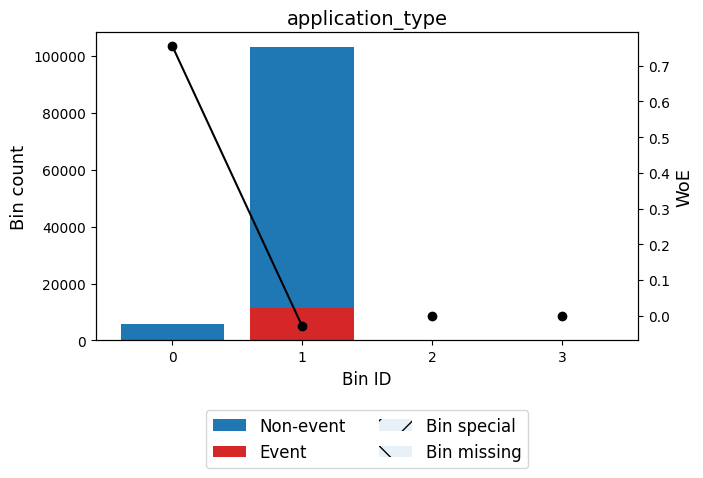

✅ Total IV for grade_numeric: 0.4628
╒══════════════╤═════════╤════════════════════╤═════════════════════╤════════════╕
│ Bin          │   Count │   Default Rate (%) │ WOE                 │         IV │
╞══════════════╪═════════╪════════════════════╪═════════════════════╪════════════╡
│ (-inf, 1.50) │   21367 │             0.0305 │ 1.3540117159145977  │ 0.214574   │
├──────────────┼─────────┼────────────────────┼─────────────────────┼────────────┤
│ [1.50, 2.50) │   32080 │             0.073  │ 0.43686334742925403 │ 0.0474212  │
├──────────────┼─────────┼────────────────────┼─────────────────────┼────────────┤
│ [2.50, 3.50) │   30893 │             0.1215 │ -0.1258006081025156 │ 0.00472041 │
├──────────────┼─────────┼────────────────────┼─────────────────────┼────────────┤
│ [3.50, 4.50) │   15628 │             0.1756 │ -0.557987555064938  │ 0.0553949  │
├──────────────┼─────────┼────────────────────┼─────────────────────┼────────────┤
│ [4.50, inf)  │    8817 │             0.2643 │ -1

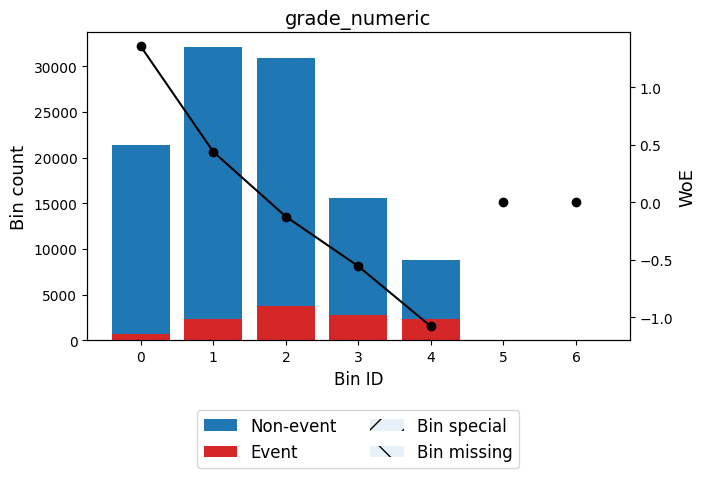

In [15]:
# ======================================================
# Start inspecting IV (Base Settings of optbinning 1st)
# ======================================================


def get_categorical_cols(df): 
    """
    Get categorical columns from a Pyspark Dataframe & Return list of categorical columns 
    """
    
    return [column.name for column in df.schema.fields if isinstance(column.dataType, StringType)]
    
categorical_features = get_categorical_cols(df)

sampled_df = df.sample(fraction=0.05, seed=42, withReplacement=False).toPandas()

for cat_feature in categorical_features: 
    if cat_feature != 'grade': 
        first_bin_and_classify_feature(cat_feature, sampled_df[cat_feature], sampled_df[TARGET_COL], dtype='categorical', monotonic_trend_type='auto')

first_bin_and_classify_feature('grade_numeric', sampled_df['grade_numeric'], sampled_df[TARGET_COL], dtype='numerical',monotonic_trend_type='auto' )
        

For categorical features, we will drop `home_ownership` and `pymnt_plan` due to unsatisfactory IV Scores (<0.02) even when they are already binned optimally. The rest of the categorical features have IV scores >= 0.02 with monotonic WoE trends, making them interpretable for credit scorecards. 

In [16]:
df = df.drop(col('home_ownership'), col('pymnt_plan'))

### 1.1.3 Actual Binning of all Features 

In [17]:
# ==============================
# Removal of Unimportant Columns
# ==============================

df = df.drop( col('id') , col('earliest_cr_line')) #! remove issue_d column later on (sort before feeding into machine learning model)

In [ ]:
# ===========================
# Binning Numerical Features 
# ===========================

def generate_woe_expr(col_name, splits, woes):
    """
    
    Generate a PySpark conditional expression to assign Weight of Evidence (WoE) values
    to a numerical column based on trained optbinning model's split points & woe values.
    
    This function constructs a series of `when` conditions that map the input column's value
    to its appropriate WoE score based on bin intervals.
    
    splits : list of float
        A list of bin boundary values (from optbinning.splits), assumed to be in ascending order.
        For example: [5000, 10000, 20000] defines bins:
            - (-inf, 5000]
            - (5000, 10000]
            - (10000, 20000]
            - (20000, +inf)
            
    woes: woe values corresponding to each bin 
    
    
    """
    expr = when(col(col_name) <= splits[0], float(woes[0])) # allocate WoE value to 1st bin 
    
    # Allocating each WoE Value in all the bins, including the last bin 
    for i in range(1, len(splits)):
        expr = expr.when(
            (col(col_name) > splits[i - 1]) & (col(col_name) <= splits[i]),
            float(woes[i])
        )
    expr = expr.otherwise(float(woes[-1]))
    return expr

def generate_woe_expr_categorical(col_name, categories, woes):
    expr = None
    for cat, woe in zip(categories, woes):
        # Ensure category is a native Python string
        cond = (col(col_name) == str(cat))
        if expr is None:
            expr = when(cond, float(woe))
        else:
            expr = expr.when(cond, float(woe))
    expr = expr.otherwise(float(woes[-1]))
    return expr

def woe_binning_transform(df, feature, target_col="default_status", date_col="issue_d", split_date="2017-08-01", monotonicity='auto', dtype='numerical'):
    """
    Fits WoE binning on train_df (split by date), then applies transformation to full df.
    
    Parameters:
    - df: PySpark DataFrame
    - feature: str, column to bin
    - target_col: str, target column for PD model (e.g. default_status)
    - date_col: str, time-based split column
    - split_date: str, boundary date for out-of-time split (e.g. '2017-08-01')
    
    Returns:
    - df: PySpark DataFrame with additional column <feature>_woe
    """

    # -- 1. Split into train set for fitting WoE --
    train_df = df.filter(col(date_col) < split_date).cache() 
    _ = train_df.count() 

    # -- 2. Convert train set to Pandas for optbinning
    train_pdf = train_df.select(feature, target_col).dropna().toPandas()

    # -- 3. Fit OptimalBinning to train set 
    optb = OptimalBinning(name=feature, dtype=dtype, monotonic_trend=monotonicity)
    
    try:
        optb.fit(train_pdf[feature], train_pdf[target_col])
    except Exception as e:
        print(f"❌ Error fitting {feature}: {e}")
        return df
    
    # -- 5. Get WoE values 
    opt_table = optb.binning_table.build()
    opt_table = opt_table.reset_index(drop=True)     
    woe_df     = opt_table[~opt_table["Bin"].astype(str)
                       .isin(["Special", "Missing",""])]
    
    woe_values = woe_df["WoE"].tolist()          
    new_col_name = feature + "_woe"

    # -- 4. Get bin edges 
    if dtype=='numerical': 
        splits      =    [-float("inf")] + list(optb.splits) + [float("inf")]

        def numeric_expr(c, s, w):
            expr = when(col(c) <= s[1], float(w[0]))
            for i in range(1, len(w)):
                expr = expr.when((col(c) > s[i]) & (col(c) <= s[i+1]), float(w[i]))
            return expr.otherwise(float(w[-1]))

        df = df.withColumn(new_col_name, numeric_expr(feature, splits, woe_values))
    else: 
        categories = woe_df["Bin"].tolist()
        woe_values = woe_df["WoE"].tolist()

        expr = None
        for cat, w in zip(categories, woe_values):
            expr = when(col(feature) == str(cat), float(w)) if expr is None else expr.when(col(feature) == str(cat), float(w))
        expr = expr.otherwise(float(woe_values[-1]))

        df = df.withColumn(new_col_name, expr)
        

    df = df.drop(col(feature))  # Drop original column
    
    train_df.unpersist()

    return df


In [19]:
# =============================================================================================================
# Conduct Automated binning using optbinning 
# manual_binning_numerical_features = ['loan_amnt', 'total_rev_hi_lim', 'tot_hi_cred_lim']
# =============================================================================================================

manual_binning_numerical_features = ['total_rev_hi_lim', 'tot_hi_cred_lim', 'loan_amnt']
rest_numerical_features = [f.name for f in df.schema.fields if isinstance(f.dataType, NumericType) and f.name not in manual_binning_numerical_features]


# 4. WoE fitting of Optbinning model based on train_df (sampled)
for num_feature in rest_numerical_features: 
    if num_feature != 'default_status': 
        print(f"🖖🏻 WoE Binning {num_feature} now ..." )
        df = woe_binning_transform(df, num_feature)
    else: 
        print('Skipping default_status ...')



🖖🏻 WoE Binning term now ...


🖖🏻 WoE Binning annual_inc now ...


Skipping default_status ...
🖖🏻 WoE Binning dti now ...
🖖🏻 WoE Binning inq_last_6mths now ...


🖖🏻 WoE Binning revol_util now ...
🖖🏻 WoE Binning acc_open_past_24mths now ...
🖖🏻 WoE Binning bc_open_to_buy now ...


🖖🏻 WoE Binning mo_sin_rcnt_rev_tl_op now ...


🖖🏻 WoE Binning mo_sin_rcnt_tl now ...


🖖🏻 WoE Binning mths_since_recent_bc now ...


🖖🏻 WoE Binning mths_since_recent_inq now ...


🖖🏻 WoE Binning num_tl_op_past_12m now ...


🖖🏻 WoE Binning fico_score now ...


🖖🏻 WoE Binning any_derog_flag now ...


🖖🏻 WoE Binning grade_numeric now ...


In [20]:
# =============================
# Binning Categorical Features 
# =============================
df = df.drop(col('grade'))

updated_cat_features = [field.name for field in df.schema.fields if isinstance(field.dataType, StringType)]

for cat_feature in updated_cat_features: 
    print(f"🖖🏻 WoE Binning {cat_feature} now ..." )
    df = woe_binning_transform(df, cat_feature, dtype='categorical', monotonicity='auto')
    
# == Remove grade columns -> converted to grade_numeric already == 
df = df.drop(col('grade'))
    

🖖🏻 WoE Binning verification_status now ...


🖖🏻 WoE Binning initial_list_status now ...


🖖🏻 WoE Binning application_type now ...


In [21]:
checkpoint = df.limit(10).toPandas()

In [22]:
# =============================
# Multicollinearity Check Again
# ============================= 

newest_numeric = [field.name for field in df.schema.fields if isinstance(field.dataType, NumericType) and field.name != 'default_status']
to_keep1, to_drop1 = calculate_vif(df,newest_numeric , threshold=5.0, sample_frac=0.05)

print("✅ Features to Keep (VIF <= 5.0):")
for feature, vif in to_keep1:
    print(f" - {feature}: {vif}")
    
print("\n❌ Features to Drop (VIF > 5.0):")
for feature, vif in to_drop1:
    print(f" - {feature}: {vif}")


25/08/02 21:23:06 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
25/08/02 21:23:06 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK
25/08/02 21:23:12 WARN Instrumentation: [3f55a50a] The standard deviation of the label is zero, so the coefficients will be zeros and the intercept will be the mean of the label; as a result, training is not needed.


✅ Features to Keep (VIF <= 5.0):
 - loan_amnt: 1.6674300187570197
 - total_rev_hi_lim: 1.9490111269728465
 - tot_hi_cred_lim: 1.7555545076550378
 - term_woe: 1.4416063784627509
 - annual_inc_woe: 1.956709616864331
 - dti_woe: 1.3036032892959246
 - inq_last_6mths_woe: 1.9311409915595303
 - revol_util_woe: 2.158084502103699
 - acc_open_past_24mths_woe: 2.5479940713520572
 - bc_open_to_buy_woe: 2.580612036535576
 - mo_sin_rcnt_rev_tl_op_woe: 2.9265251635239804
 - mo_sin_rcnt_tl_woe: 2.780995982839316
 - mths_since_recent_bc_woe: 1.9994968714102623
 - mths_since_recent_inq_woe: 1.9028344189113484
 - num_tl_op_past_12m_woe: 3.1934427809847024
 - fico_score_woe: 2.153967260502458
 - any_derog_flag_woe: 1.2128568415932592
 - grade_numeric_woe: 1.860750277148196
 - verification_status_woe: 0.0
 - initial_list_status_woe: 0.0

❌ Features to Drop (VIF > 5.0):


25/08/02 21:23:13 WARN Instrumentation: [1c076538] Mean and standard deviation of the label are zero, so the coefficients and the intercept will all be zero; as a result, training is not needed.


In [ ]:
run_model_checkpoint(df, "logistic_regression_aft_feature_selection", '2017-08-01', 0.05, 
                     , 'pd_model_building_2')

Accuracy,▁
F1 Score,▁
Gini,▁
Precision,▁
Recall,▁
Accuracy,0.67438
F1 Score,0.78098
Gini,0.40528
Model Type,logistic_regression_...
Precision,0.95687
Recall,0.67438


In [24]:
# ====================================
# Prevent re-running of whole notebook
# ====================================
 
df1 = df 

df1.limit(5).toPandas()

,loan_amnt,issue_d,default_status,total_rev_hi_lim,tot_hi_cred_lim,term_woe,annual_inc_woe,dti_woe,inq_last_6mths_woe,revol_util_woe,...,mo_sin_rcnt_tl_woe,mths_since_recent_bc_woe,mths_since_recent_inq_woe,num_tl_op_past_12m_woe,fico_score_woe,any_derog_flag_woe,grade_numeric_woe,verification_status_woe,initial_list_status_woe,application_type_woe
0,20000.0,2014-05-01,0,8700.0,228569.0,-0.433358,-0.088393,-0.286120,-0.110647,-0.019313,...,0.244826,0.309349,-0.269235,0.203031,-0.261071,0.061497,-0.994017,-0.247501,-0.095668,0.0
1,20000.0,2014-05-01,1,34600.0,250522.0,-0.433358,-0.101618,0.020951,-0.110647,-0.083682,...,-0.285631,-0.251908,-0.269235,-0.179358,-0.261071,0.061497,-0.994017,-0.247501,-0.095668,0.0
2,4800.0,2014-05-01,0,8300.0,8300.0,0.211215,-0.208025,-0.442713,0.164247,0.232712,...,-0.003341,-0.112706,0.140065,-0.315970,-0.215742,-0.107528,0.453601,-0.247501,-0.095668,0.0
3,10000.0,2014-05-01,1,18800.0,268285.0,-0.433358,-0.101618,0.194983,0.164247,-0.000324,...,-0.047195,-0.112706,0.140065,-0.179358,-0.004668,-0.107528,-0.087104,-0.247501,-0.095668,0.0
4,27000.0,2014-05-01,0,26300.0,35596.0,-0.433358,-0.088393,0.020951,0.164247,-0.083682,...,0.139697,0.071599,0.159881,0.203031,-0.004668,0.061497,-0.087104,-0.247501,-0.095668,0.0


In [25]:
df1.columns

['loan_amnt',
 'issue_d',
 'default_status',
 'total_rev_hi_lim',
 'tot_hi_cred_lim',
 'term_woe',
 'annual_inc_woe',
 'dti_woe',
 'inq_last_6mths_woe',
 'revol_util_woe',
 'acc_open_past_24mths_woe',
 'bc_open_to_buy_woe',
 'mo_sin_rcnt_rev_tl_op_woe',
 'mo_sin_rcnt_tl_woe',
 'mths_since_recent_bc_woe',
 'mths_since_recent_inq_woe',
 'num_tl_op_past_12m_woe',
 'fico_score_woe',
 'any_derog_flag_woe',
 'grade_numeric_woe',
 'verification_status_woe',
 'initial_list_status_woe',
 'application_type_woe']

In [26]:
bruh = df1.limit(10).toPandas()
bruh

,loan_amnt,issue_d,default_status,total_rev_hi_lim,tot_hi_cred_lim,term_woe,annual_inc_woe,dti_woe,inq_last_6mths_woe,revol_util_woe,...,mo_sin_rcnt_tl_woe,mths_since_recent_bc_woe,mths_since_recent_inq_woe,num_tl_op_past_12m_woe,fico_score_woe,any_derog_flag_woe,grade_numeric_woe,verification_status_woe,initial_list_status_woe,application_type_woe
0,20000.0,2014-05-01,0,8700.0,228569.0,-0.433358,-0.088393,-0.286120,-0.110647,-0.019313,...,0.244826,0.309349,-0.269235,0.203031,-0.261071,0.061497,-0.994017,-0.247501,-0.095668,0.0
1,20000.0,2014-05-01,1,34600.0,250522.0,-0.433358,-0.101618,0.020951,-0.110647,-0.083682,...,-0.285631,-0.251908,-0.269235,-0.179358,-0.261071,0.061497,-0.994017,-0.247501,-0.095668,0.0
2,4800.0,2014-05-01,0,8300.0,8300.0,0.211215,-0.208025,-0.442713,0.164247,0.232712,...,-0.003341,-0.112706,0.140065,-0.315970,-0.215742,-0.107528,0.453601,-0.247501,-0.095668,0.0
3,10000.0,2014-05-01,1,18800.0,268285.0,-0.433358,-0.101618,0.194983,0.164247,-0.000324,...,-0.047195,-0.112706,0.140065,-0.179358,-0.004668,-0.107528,-0.087104,-0.247501,-0.095668,0.0
4,27000.0,2014-05-01,0,26300.0,35596.0,-0.433358,-0.088393,0.020951,0.164247,-0.083682,...,0.139697,0.071599,0.159881,0.203031,-0.004668,0.061497,-0.087104,-0.247501,-0.095668,0.0
5,8400.0,2014-05-01,0,17600.0,17600.0,0.211215,0.052651,0.355848,-0.110647,-0.083682,...,-0.088563,-0.058883,-0.084736,0.003019,0.220221,0.061497,0.453601,-0.247501,-0.095668,0.0
6,10000.0,2014-05-01,0,11100.0,101200.0,0.211215,-0.013528,0.094664,-0.372610,-0.083682,...,-0.285631,0.109028,-0.269235,0.203031,-0.048943,0.061497,0.453601,-0.247501,-0.095668,0.0
7,10800.0,2014-05-01,0,18200.0,29200.0,-0.433358,-0.195126,0.194983,0.164247,-0.083682,...,0.244826,-0.025962,0.159881,0.398455,-0.004668,0.061497,-0.087104,-0.247501,-0.095668,0.0
8,20000.0,2014-05-01,1,25000.0,50150.0,0.211215,0.131261,0.194983,-0.110647,-0.109645,...,-0.285631,-0.067815,-0.269235,0.003019,-0.175785,0.061497,0.453601,-0.247501,-0.095668,0.0
9,7800.0,2014-05-01,1,22400.0,106462.0,0.211215,-0.195126,-0.219680,0.164247,0.073563,...,0.244826,0.016099,0.159881,0.398455,0.078036,-0.107528,0.453601,-0.247501,-0.095668,0.0


In [27]:
# ================================================
# Easy Reference for subsequent feature importance 
# ================================================

# == 1. Get all columns with woe in it 
woe_cols = [colname for colname in df1.columns if '_woe' in colname]
print("WOE Columns:", woe_cols)

WOE Columns: ['term_woe', 'annual_inc_woe', 'dti_woe', 'inq_last_6mths_woe', 'revol_util_woe', 'acc_open_past_24mths_woe', 'bc_open_to_buy_woe', 'mo_sin_rcnt_rev_tl_op_woe', 'mo_sin_rcnt_tl_woe', 'mths_since_recent_bc_woe', 'mths_since_recent_inq_woe', 'num_tl_op_past_12m_woe', 'fico_score_woe', 'any_derog_flag_woe', 'grade_numeric_woe', 'verification_status_woe', 'initial_list_status_woe', 'application_type_woe']


In [ ]:

# acc_optn_past_24mths & revol_util: When both are high, amplified red flag (financial desparation)
# num_tl_op_past_12m & any_derog_flag_woe: Any signs of public record/collections and high number of tradelines opened amplifies risk 
# num_tl_op_past_12m & inq_last_6mths: Financial desperation amplifies credit risk 
# any_derog_flag_woe & inq_last_6_mths: Any major signs & high credit inquries should amplify risk 
# dti & inquiries: High debt & high number of inquiries amplify risk 
# dti & fico score: Having high debt relative to income, yet a low fico score amplifies risk 
# dti % derog_flag: Amplifies credit risk 
# dti & revol_util: Someone who has high debt to income, and spends near his credit limits are more likely to default
# revol_util & derog_flag: Someone who spends near his limits, and have bad track records should be flagged by model 

from pyspark.sql.functions import col, lit









✅ Total IV for fico_score_loan_amnt: 0.1555
╒════════════════╤═════════╤════════════════════╤══════════════════════╤═════════════╕
│ Bin            │   Count │   Default Rate (%) │ WOE                  │          IV │
╞════════════════╪═════════╪════════════════════╪══════════════════════╪═════════════╡
│ (-inf, -0.00)  │    5615 │             0.112  │ -0.03429906928718918 │ 6.15419e-05 │
├────────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [-0.00, -0.00) │    6803 │             0.1219 │ -0.12960523302949167 │ 0.00110495  │
├────────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [-0.00, -0.00) │    6977 │             0.1326 │ -0.22620673927443047 │ 0.00358377  │
├────────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [-0.00, -0.00) │    5774 │             0.1573 │ -0.4257739319280771  │ 0.0113409   │
├────────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤

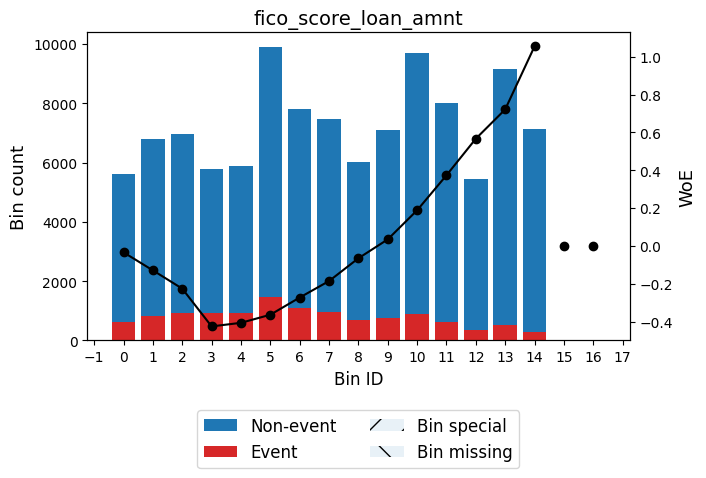

✅ Total IV for loan_amnt_annual_inc_woe_ratio: 0.0417
╒══════════════════════╤═════════╤════════════════════╤══════════════════════╤═════════════╕
│ Bin                  │   Count │   Default Rate (%) │ WOE                  │          IV │
╞══════════════════════╪═════════╪════════════════════╪══════════════════════╪═════════════╡
│ (-inf, 3655.55)      │    5523 │             0.073  │ 0.43741607941661886  │ 0.00818309  │
├──────────────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [3655.55, 5286.39)   │    6145 │             0.0845 │ 0.2786930292136618   │ 0.003933    │
├──────────────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [5286.39, 6701.94)   │    7711 │             0.0875 │ 0.23952533831466738  │ 0.00370202  │
├──────────────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [6701.94, 9734.64)   │   15126 │             0.0915 │ 0.1909219027431548   │ 0.0047027   │
├───────────────

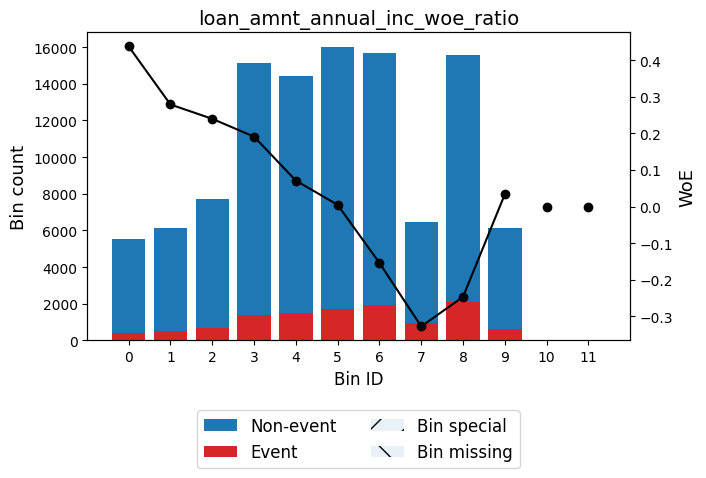

✅ Total IV for bc_open_to_buy_annual_inc_woe_ratio: 0.1039
╒════════════════╤═════════╤════════════════════╤═══════════════════════╤═════════════╕
│ Bin            │   Count │   Default Rate (%) │ WOE                   │          IV │
╞════════════════╪═════════╪════════════════════╪═══════════════════════╪═════════════╡
│ (-inf, -0.25)  │    6190 │             0.1578 │ -0.4301329439449286   │ 0.0124286   │
├────────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ [-0.25, -0.20) │    6370 │             0.1438 │ -0.32046887793884804  │ 0.00680954  │
├────────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ [-0.20, -0.17) │    9546 │             0.141  │ -0.2975601536225805   │ 0.00872095  │
├────────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ [-0.17, -0.13) │   11969 │             0.1293 │ -0.1976978508274967   │ 0.00464446  │
├────────────────┼─────────┼────────────────────┼────────────

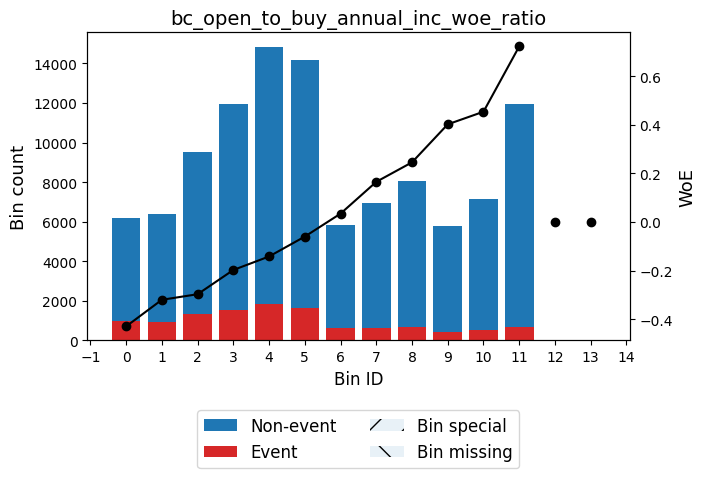

✅ Total IV for acc_open24m_revol_util: 0.0370
╒════════════════╤═════════╤════════════════════╤══════════════════════╤═════════════╕
│ Bin            │   Count │   Default Rate (%) │ WOE                  │          IV │
╞════════════════╪═════════╪════════════════════╪══════════════════════╪═════════════╡
│ (-inf, -0.02)  │   31719 │             0.0977 │ 0.11882689545394598  │ 0.00392963  │
├────────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [-0.02, -0.01) │   15110 │             0.1034 │ 0.05500099248900803  │ 0.000411226 │
├────────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [-0.01, 0.00)  │   16789 │             0.1122 │ -0.03565950988576505 │ 0.000199005 │
├────────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [0.00, 0.01)   │    9724 │             0.1164 │ -0.07771151868473414 │ 0.00055646  │
├────────────────┼─────────┼────────────────────┼──────────────────────┼────────────

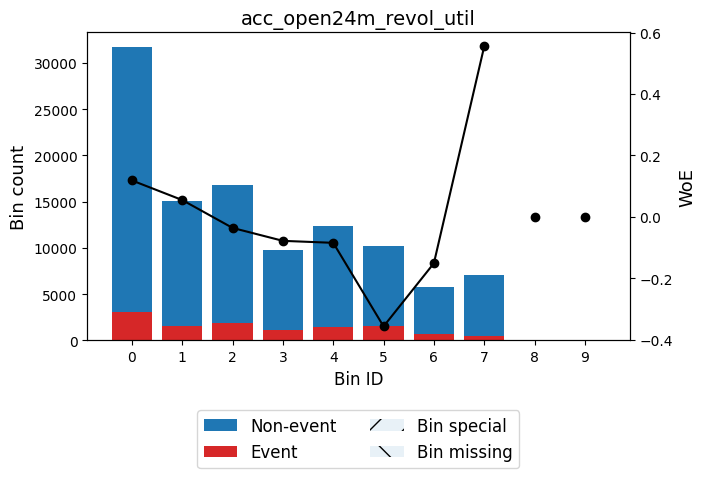

✅ Total IV for tl_op12m_delinq: 0.0588
╒═══════════════╤═════════╤════════════════════╤══════════════════════╤═════════════╕
│ Bin           │   Count │   Default Rate (%) │ WOE                  │          IV │
╞═══════════════╪═════════╪════════════════════╪══════════════════════╪═════════════╡
│ (-inf, -0.00) │   45313 │             0.1203 │ -0.11534967782952776 │ 0.00579754  │
├───────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [-0.00, 0.01) │   18147 │             0.1054 │ 0.034462514255348076 │ 0.000195465 │
├───────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [0.01, 0.02)  │   24126 │             0.0959 │ 0.13892557162207853  │ 0.00405347  │
├───────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [0.02, 0.03)  │   13925 │             0.0669 │ 0.5302761385268937   │ 0.0292433   │
├───────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [0.03, inf)  

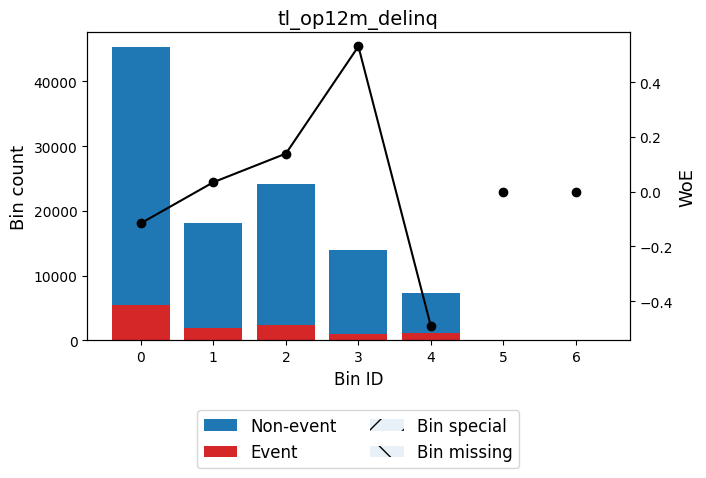

✅ Total IV for tl_op12m_inq6m: 0.0795
╒═══════════════╤═════════╤════════════════════╤═══════════════════════╤═════════════╕
│ Bin           │   Count │   Default Rate (%) │ WOE                   │          IV │
╞═══════════════╪═════════╪════════════════════╪═══════════════════════╪═════════════╡
│ (-inf, -0.05) │   10002 │             0.1328 │ -0.22790108231131945  │ 0.00521825  │
├───────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ [-0.05, 0.00) │   28120 │             0.1145 │ -0.058719865680107564 │ 0.00091198  │
├───────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ [0.00, 0.03)  │   20611 │             0.1097 │ -0.010734695465505428 │ 2.19247e-05 │
├───────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ [0.03, 0.06)  │   25410 │             0.0971 │ 0.12500410914568283   │ 0.00347539  │
├───────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ [0.

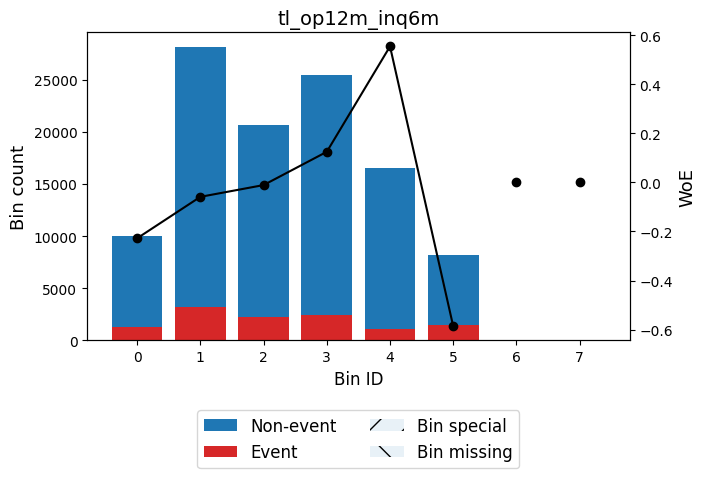

✅ Total IV for derog_inq: 0.0727
╒═══════════════╤═════════╤════════════════════╤════════════════════════╤═════════════╕
│ Bin           │   Count │   Default Rate (%) │ WOE                    │          IV │
╞═══════════════╪═════════╪════════════════════╪════════════════════════╪═════════════╡
│ (-inf, -0.02) │    8599 │             0.1575 │ -0.42730867538768935   │ 0.0170214   │
├───────────────┼─────────┼────────────────────┼────────────────────────┼─────────────┤
│ [-0.02, 0.00) │   38824 │             0.1088 │ -0.0014859410105336757 │ 7.88473e-07 │
├───────────────┼─────────┼────────────────────┼────────────────────────┼─────────────┤
│ [0.00, 0.01)  │   46103 │             0.0853 │ 0.2677494976385444     │ 0.0273528   │
├───────────────┼─────────┼────────────────────┼────────────────────────┼─────────────┤
│ [0.01, 0.03)  │    9688 │             0.1345 │ -0.24278197953778746   │ 0.00576908  │
├───────────────┼─────────┼────────────────────┼────────────────────────┼─────────────┤

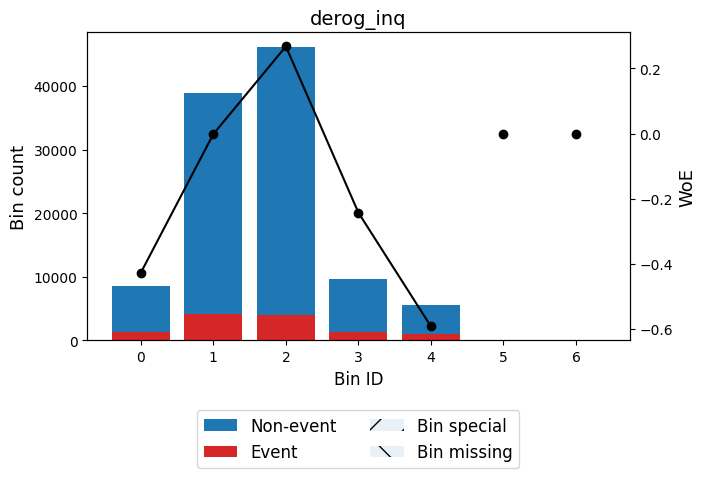

✅ Total IV for dti_inq: 0.0199
╒════════════════╤═════════╤════════════════════╤═══════════════════════╤═════════════╕
│ Bin            │   Count │   Default Rate (%) │ WOE                   │          IV │
╞════════════════╪═════════╪════════════════════╪═══════════════════════╪═════════════╡
│ (-inf, -0.06)  │   12654 │             0.1311 │ -0.21333146387183488  │ 0.00575225  │
├────────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ [-0.06, -0.05) │    5625 │             0.1207 │ -0.11884375614758635  │ 0.000764987 │
├────────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ [-0.05, 0.03)  │   58258 │             0.1086 │ 0.0005326475275211351 │ 1.51906e-07 │
├────────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ [0.03, 0.04)   │    6572 │             0.0949 │ 0.1501028625403662    │ 0.00128336  │
├────────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│

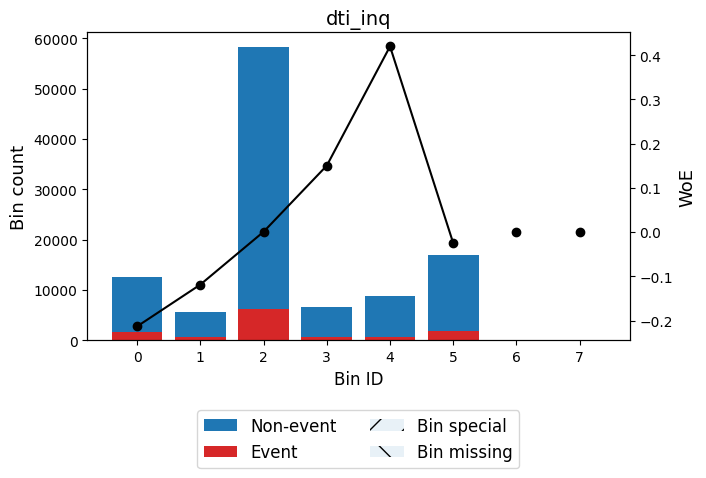

✅ Total IV for dti_fico_ratio: 0.0792
╒════════════════╤═════════╤════════════════════╤══════════════════════╤═════════════╕
│ Bin            │   Count │   Default Rate (%) │ WOE                  │          IV │
╞════════════════╪═════════╪════════════════════╪══════════════════════╪═════════════╡
│ (-inf, -0.41)  │    8028 │             0.1862 │ -0.629817027654288   │ 0.0372258   │
├────────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [-0.41, -0.24) │   10924 │             0.1389 │ -0.2798376840468326  │ 0.00876659  │
├────────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [-0.24, -0.12) │   14256 │             0.1207 │ -0.11827686244189373 │ 0.00191991  │
├────────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [-0.12, -0.02) │   13456 │             0.1068 │ 0.019374047203512212 │ 4.6078e-05  │
├────────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [-0

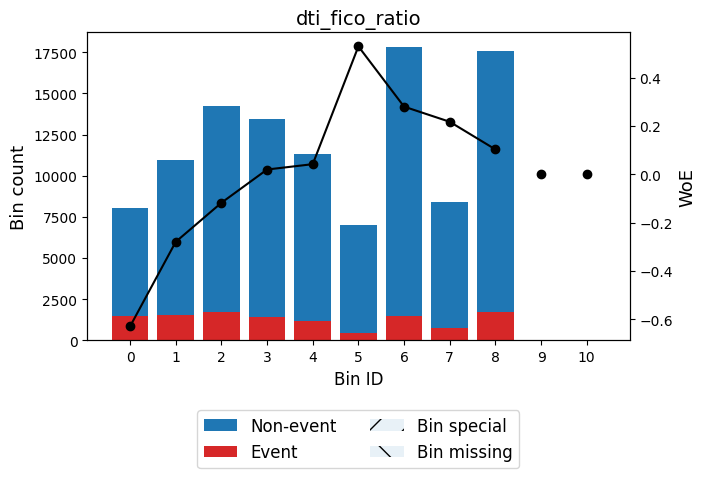

✅ Total IV for dti_derog: 0.0181
╒═══════════════╤═════════╤════════════════════╤══════════════════════╤═════════════╕
│ Bin           │   Count │   Default Rate (%) │ WOE                  │          IV │
╞═══════════════╪═════════╪════════════════════╪══════════════════════╪═════════════╡
│ (-inf, -0.03) │    7956 │             0.0946 │ 0.15363058041921773  │ 0.00162525  │
├───────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [-0.03, 0.03) │   94789 │             0.1062 │ 0.025555483773549437 │ 0.000563394 │
├───────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [0.03, inf)   │    6040 │             0.1656 │ -0.48715099458697453 │ 0.0158932   │
├───────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ Special       │       0 │             0      │ 0.0                  │ 0           │
├───────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ Missing       │    

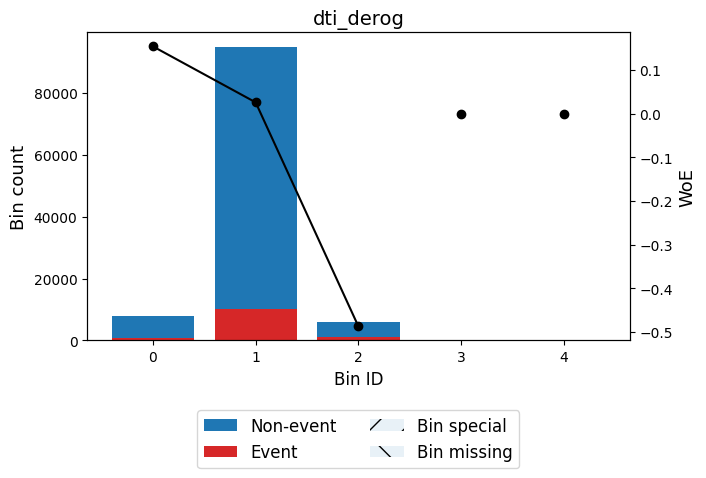

✅ Total IV for dti_revol_util: 0.0346
╒════════════════╤═════════╤════════════════════╤═══════════════════════╤═════════════╕
│ Bin            │   Count │   Default Rate (%) │ WOE                   │          IV │
╞════════════════╪═════════╪════════════════════╪═══════════════════════╪═════════════╡
│ (-inf, -0.03)  │   10393 │             0.0948 │ 0.1521169522960677    │ 0.00208269  │
├────────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ [-0.03, -0.02) │    7483 │             0.1022 │ 0.06811285967545055   │ 0.000310725 │
├────────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ [-0.02, -0.00) │   19800 │             0.1078 │ 0.008561557460268876  │ 1.32968e-05 │
├────────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ [-0.00, 0.00)  │   11786 │             0.1089 │ -0.002971566722353547 │ 9.57797e-07 │
├────────────────┼─────────┼────────────────────┼───────────────────────┼─────────

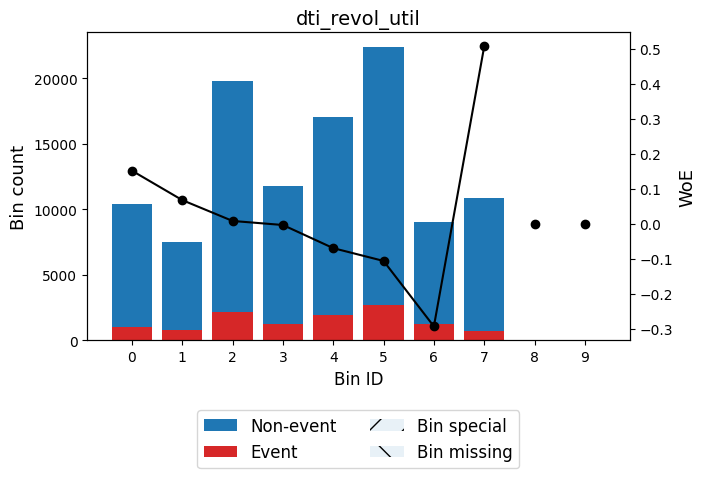

✅ Total IV for revol_util_derog: 0.0405
╒═══════════════╤═════════╤════════════════════╤══════════════════════╤════════════╕
│ Bin           │   Count │   Default Rate (%) │ WOE                  │         IV │
╞═══════════════╪═════════╪════════════════════╪══════════════════════╪════════════╡
│ (-inf, -0.02) │    6639 │             0.0997 │ 0.09585141621699433  │ 0.00054003 │
├───────────────┼─────────┼────────────────────┼──────────────────────┼────────────┤
│ [-0.02, 0.01) │   75224 │             0.1132 │ -0.04564916248485584 │ 0.00146691 │
├───────────────┼─────────┼────────────────────┼──────────────────────┼────────────┤
│ [0.01, 0.01)  │   12223 │             0.135  │ -0.2470287828323512  │ 0.00754786 │
├───────────────┼─────────┼────────────────────┼──────────────────────┼────────────┤
│ [0.01, 0.02)  │    8014 │             0.0742 │ 0.4186810739736444   │ 0.0109584  │
├───────────────┼─────────┼────────────────────┼──────────────────────┼────────────┤
│ [0.02, inf)   │    6685

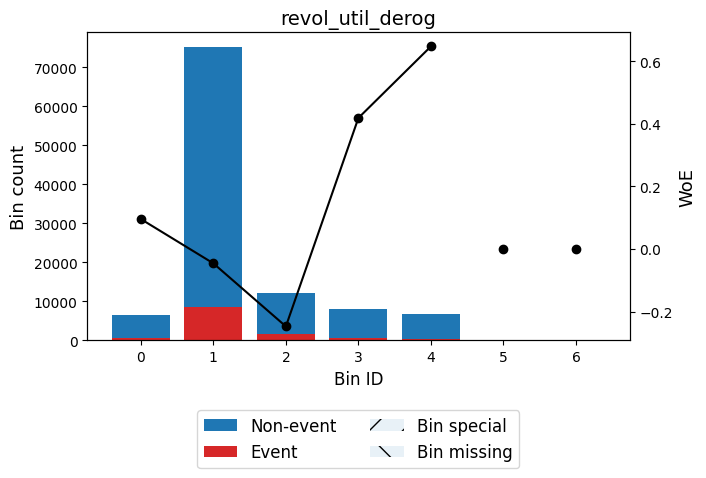

In [30]:
interaction_features = [
    "fico_score_loan_amnt",
    "loan_amnt_annual_inc_woe_ratio",
    "bc_open_to_buy_annual_inc_woe_ratio",
    "acc_open24m_revol_util",
    "tl_op12m_delinq",
    "tl_op12m_inq6m",
    "derog_inq",
    "dti_inq",
    "dti_fico_ratio",
    "dti_derog",
    "dti_revol_util",
    "revol_util_derog"
]
sample_pdf = df1.select(*interaction_features, 'default_status').sample(fraction=0.05, seed=42).toPandas() 


for feature in interaction_features:
    x = sample_pdf[feature]
    y = sample_pdf['default_status']
    
    first_bin_and_classify_feature(feature, x , y, dtype='numerical')  


In [31]:
for key, value in iv_categories.items(): 
    print("👑 " + key.capitalize())
    
    for a_tuple in value: 
        print(a_tuple)

👑 Useless (< 0.02)
('delinq_2yrs', np.float64(0.006762143980521645))
('pub_rec', np.float64(0.009782467672196097))
('collections_12_mths_ex_med', np.float64(0.0))
('acc_now_delinq', np.float64(0.0))
('chargeoff_within_12_mths', np.float64(0.0))
('delinq_amnt', np.float64(0.0))
('mo_sin_old_il_acct', np.float64(0.006667886616433656))
('mort_acc', np.float64(0.007931255732181569))
('num_accts_ever_120_pd', np.float64(0.004828682959684444))
('num_bc_tl', np.float64(0.007588933088295326))
('num_il_tl', np.float64(0.007374777416292187))
('num_tl_120dpd_2m', np.float64(0.0))
('num_tl_90g_dpd_24m', np.float64(0.0030080340689503313))
('pct_tl_nvr_dlq', np.float64(0.0005845470624135888))
('total_bal_ex_mort', np.float64(0.011270811148483977))
('credit_history_years', np.float64(0.009731113652143332))
('proportion_satisfac_accounts', np.float64(0.012058325285492577))
('proportion_satisfac_bc_tl', np.float64(0.01026338586727132))
('home_ownership', np.float64(0.017853172152602216))
('pymnt_plan',

In [34]:
import pandas as pd
import matplotlib.pyplot as plt

# Example: Suppose iv_categories is a dict {category_name: [(feature, iv_value), ...], ...}
# To log all features and their IV values, flatten iv_categories to a list of tuples
iv_list = []
for category, feature_list in iv_categories.items():
    for feature, iv_value in feature_list:
        # Append tuples (category, feature, iv_value)
        iv_list.append((category, feature, float(iv_value)))  # Convert np.float64 to native float for compatibility

# Create a DataFrame for easier logging and viewing
iv_df = pd.DataFrame(iv_list, columns=["Category", "Feature", "IV"]).sort_values("IV", ascending=False)
iv_df["Feature"] = pd.Categorical(iv_df["Feature"], categories=iv_df["Feature"], ordered=True)

# Initialize wandb - replace project and name with your own
wandb.init(project="Credit Risk Modeling", name="woe_iv_logging")
wandb.log({"IV Table": wandb.Table(dataframe=iv_df)})

# Prepare data for wandb bar chart (feature vs IV)
chart_data = iv_df[["Feature", "IV"]]
table = wandb.Table(dataframe=chart_data)

# Log the IV bar chart
wandb.log({
    "IV Bar Chart": wandb.plot.bar(
        table, "Feature", "IV", title="Information Value by Feature"
    )
})
wandb.finish()
